In [ ]:
import ctypes
import numpy as np
from PIL import Image, ImageOps, ImageEnhance
import os.path
from os import listdir
from os.path import isfile, join
from datetime import datetime
import random
import math
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D

# Guess My Characters

http://92.222.76.60/app.php

CAO Song Toan / PINTO Thomas / LECONTE Guillaume

## But du jeu

Quand il a fallu choisir notre problématique, nous voulions un projet qui soit intéressant et amusant pour nous.
Nous avons donc choisi de classer des personnages d'animes.

Premier problème, comment créer un algorithme capable de reconnaître un personnage dans une image ?

- Solution triviale, prendre en compte tous les cas de figure et faire des conditions dessus. Malheureusement, ce n'est pas possible, il existe une infinité d'images différentes et donc faire une liste exhaustive est impossible.

- Deuxième solution créer un algorithme qui "apprendrait tout seul" à reconnaîre les personnages. Cela parait difficile, normal ça l'est, mais d'autres sont passés avant nous donc nous bénéficions d'une base pour construire. 

Nous allons donc partir sur du machine learning. Procédé qui consiste à entrainer un modèle avec beaucoup de données, afin que ce dernier découvre tout seul comment reconnaitre un personnage.

## Préparation du dataset

L'un des gros aspects du machine learning est la construction d'un dataset viable pour l'entrainement des modèles.

Afin de coller à nos attentes nous avons choisi d'entrainer nos modèles avec des images issues de fanart, et ce pour deux raisons.

Pour commencer une petite définition d'un fanart. Un fanart désigne en anglais toutes oeuvres réalisées par un fan et s’inspirant (ou reproduisant) d'un ou de plusieurs personnages, d'une scène, ou de l’univers, d’une œuvre existante.

En lisant cette définition peut-être avez-vous saisi les raisons qui nous ont poussés à utiliser ce type d'image.

En effet chaque fanart étant réalisé par une personne différente, cela nous donne un éventail de style graphique très large.

Deuxièmement, la quantité de fanart existant est ahurissante, cela nous facilitera la tâche pour récupérer le plus d'images possibles.

### Récupération des images

Afin de récupérer les images, nous avons développé un petit scrapper en C#, qui s'occupait de prendre les images sur un site regroupant un très grand nombre de fanart (https://www.zerochan.net/).

Nous avons commencé avec trois classes, et nous avons essayé de prendre des personnages assez populaires pour avoir des données plus facilement.

Dans l'ordre : Rem (Re:Zero) / C.C. (Code Geass) / Makise Kurisu (Steins;Gate)
<img src="img/mosaic.png">

Voici le nombre d'images récupéré pour chaque fille :


*   Rem    :  470
*   CC     :  404
*   Makise :  423

Etant trois dans le groupe, nous avons chacun pris un dossier et nous avons vérifié que les images correspondaient bien au personnage.

Nous avons retiré les images qui :

*   Ne correspondaient pas au personnage
*   Avaient plusieurs personnages
*   étaient très mal cadrées
*   le personnage était trop petit

Voici un petit exemple des images qui compose notre dataset :

<img src="img/dataset_sample.png">

Lors de la création du dataset nous nous sommes "heurté à un problème" atypique, bien que celui-ci ne soit pas fondamentalement néfaste pour l'entrainement des modèles.

Nous avons fait l'expérience de l'imagination débordante des fans pour représenter leurs idoles dans des positions plus que suggestives. En soi cela ne représentait pas de problème pour l'entrainement, mais nous avons préféré enlever ces images du dataset.

Une autre question a été soulevée pendant cette phase, à quel point pouvions-nous être permissif dans le style graphique. En effet, un même personnage dessiné avec deux styles peut ne pas ressembler du tous au modèle de base.

Cette question n'ayant pas de solution absolue, cela s'est fait avec notre ressenti, par exemple nous avons limité les dessins crayons.

### Affichage d'images du dataset

In [ ]:
# Chargement du dataset en mémoire
dataset = "dataset"
images = [f for f in listdir(dataset) if isfile(join(dataset, f))]

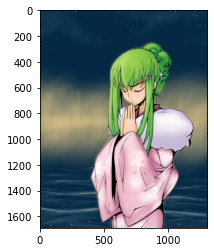

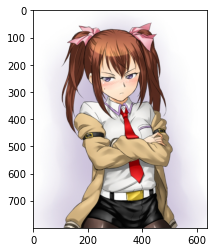

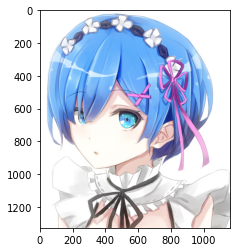

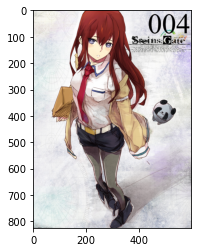

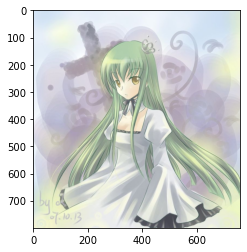

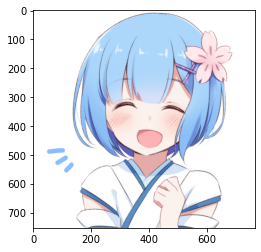

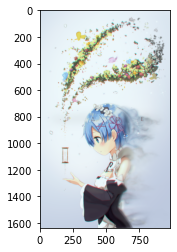

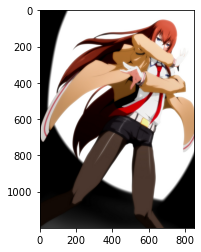

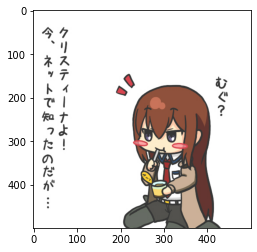

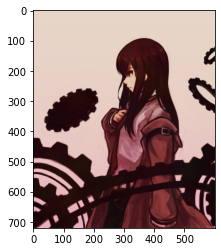

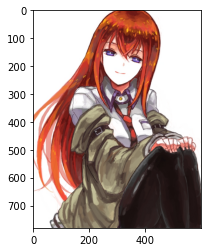

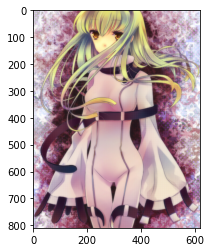

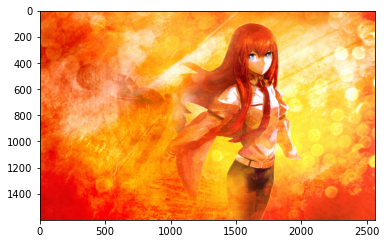

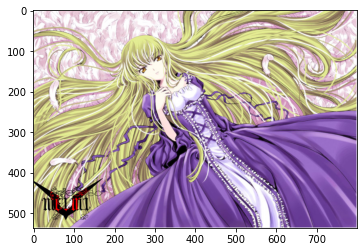

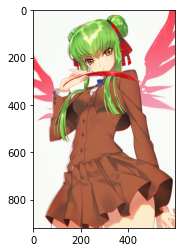

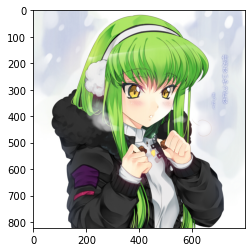

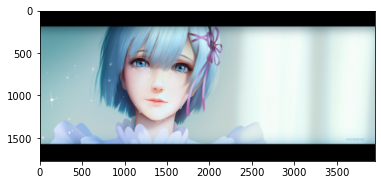

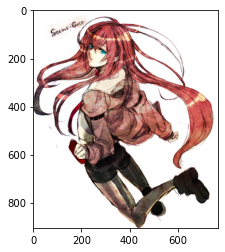

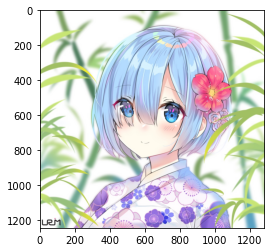

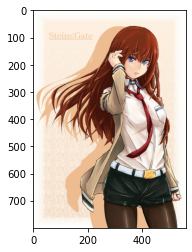

In [ ]:
# Affiche des images du dataset
nombre_image = 20

for i in range(nombre_image):
    r = random.randint(0, np.array(images).shape[0] - 2)
    img = mpimg.imread(dataset + '/' + images[r])
    imgplot = plt.imshow(img)
    plt.show()

# Algorithmes

## Chargement de la lib

In [ ]:
# Chargement lib
path_to_dll = "libC.dll"
my_lib = ctypes.CDLL(path_to_dll)

### Modèle Linéaire

In [ ]:
# ------------------------------------------------------------------------
# Définitions méthodes modèle linéaire
# Create
my_lib.linear_create_model.argtypes = [ctypes.c_int]
my_lib.linear_create_model.restype = ctypes.c_void_p

# Predict regression
my_lib.linear_predict_model_regression.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_int
]
my_lib.linear_predict_model_regression.restype = ctypes.c_double

# Train regression
my_lib.linear_train_model_regression.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_double),
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_int,
    ctypes.c_int
]
my_lib.linear_train_model_regression.restype = None

# Predict classification
my_lib.linear_predict_model_classification.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_int
]
my_lib.linear_predict_model_classification.restype = ctypes.c_double

#Train classification
my_lib.linear_train_model_classification.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_double),
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_int,
    ctypes.c_int,
    ctypes.c_double,
    ctypes.c_int
]
my_lib.linear_train_model_classification.restype = None

# Save model
my_lib.linear_save_model.argtypes = [ctypes.c_void_p, ctypes.c_int, ctypes.c_char_p]
my_lib.linear_save_model.restype = None

# Load model
my_lib.linear_load_model.argtypes = [ctypes.c_char_p]
my_lib.linear_load_model.restype = ctypes.c_void_p

# Dispose
my_lib.linear_dispose_model.argtypes = [ctypes.c_void_p, ctypes.c_int]
my_lib.linear_dispose_model.restype = None

### MLP

In [ ]:
# ------------------------------------------------------------------------
# Définitions méthodes MLP
# Create
my_lib.mlp_create_model.argtypes = [
    ctypes.POINTER(ctypes.c_int),
    ctypes.c_int
]
my_lib.mlp_create_model.restype = ctypes.c_void_p

# Predicte regression
my_lib.mlp_predict_regression.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_double)
]
my_lib.mlp_predict_regression.restype = ctypes.POINTER(ctypes.c_double)

# Train regression
my_lib.mlp_train_regression.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_int,
    ctypes.c_int,
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_int,
    ctypes.c_double,
    ctypes.c_int
]
my_lib.mlp_train_regression.restype = None

# Predicte classification
my_lib.mlp_predict_classification.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_double)
]
my_lib.mlp_predict_classification.restype = ctypes.POINTER(ctypes.c_double)

# Train classification
my_lib.mlp_train_classification.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_int,
    ctypes.c_int,
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_int,
    ctypes.c_double,
    ctypes.c_int
]
my_lib.mlp_train_classification.restype = None

# Function permettant de récupérer des metrics (boucle sur tous le dataset passé en paramètre)
# Renvoie le loss (mse), l'accuracy et la matrice de confusion
my_lib.mlp_get_metrics.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_int,
    ctypes.c_int,
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_bool
]
my_lib.mlp_get_metrics.restype = ctypes.POINTER(ctypes.c_double)

# Train classification with losses
my_lib.train_with_retrieve_metrics.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_int,
    ctypes.c_int,
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_int,
    ctypes.c_double,
    ctypes.c_bool,
    ctypes.c_bool
]
my_lib.train_with_retrieve_metrics.restype = ctypes.POINTER(ctypes.c_double)

# Save model
my_lib.mlp_save_model.argtypes = [ctypes.c_void_p, ctypes.c_char_p]
my_lib.mlp_save_model.restype = None

# Load model
my_lib.mlp_load_model.argtypes = [ctypes.c_char_p]
my_lib.mlp_load_model.restype = ctypes.c_void_p

# Dispose
my_lib.mlp_dispose.argtypes = [ctypes.c_void_p]
my_lib.mlp_dispose.restype = None

### RBF

In [ ]:
# ------------------------------------------------------------------------
# Définitions méthodes RBF
# Create
my_lib.rbf_create_model.argtypes = [ctypes.c_int, ctypes.c_int]
my_lib.rbf_create_model.restype = ctypes.c_void_p

# Train RBF
my_lib.rbf_train.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_int,
    ctypes.c_int,
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_int,
    ctypes.c_int,
    ctypes.c_double
]
my_lib.rbf_train.restype = None

# Predict classi
my_lib.rbf_predict_classification.argtypes = [ctypes.c_void_p, ctypes.POINTER(ctypes.c_double)]
my_lib.rbf_predict_classification.restype = ctypes.POINTER(ctypes.c_double)

# Predict regression
my_lib.rbf_predict_regression.argtypes = [ctypes.c_void_p, ctypes.POINTER(ctypes.c_double)]
my_lib.rbf_predict_regression.restype = ctypes.POINTER(ctypes.c_double)

# Save model
my_lib.rbf_save_model.argtypes = [ctypes.c_void_p, ctypes.c_char_p]
my_lib.rbf_save_model.restype = None

# Load model
my_lib.rbf_load_model.argtypes = [ctypes.c_char_p]
my_lib.rbf_load_model.restype = ctypes.c_void_p

# Dispose
my_lib.rbf_dispose.argtypes = [ctypes.c_void_p]
my_lib.rbf_dispose.restype = None

# Get clusters
my_lib.rbf_get_clusters.argtypes = [ctypes.c_void_p]
my_lib.rbf_get_clusters.restype = ctypes.POINTER(ctypes.c_double)

### SVM

In [ ]:
# ------------------------------------------------------------------------
# Définitions méthodes SVM
# Create
my_lib.svm_create_model.argtypes = [ctypes.c_int]
my_lib.svm_create_model.restype = ctypes.c_void_p

# Train SVM
my_lib.svm_train_model.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_int,
    ctypes.c_int,
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_bool
]
my_lib.svm_train_model.restype = None

# Predict regression
my_lib.svm_predict.argtypes = [ctypes.c_void_p, ctypes.POINTER(ctypes.c_double)]
my_lib.svm_predict.restype = ctypes.c_int

# Save model
my_lib.svm_save_model.argtypes = [ctypes.c_void_p, ctypes.c_char_p]
my_lib.svm_save_model.restype = None

# Load model
my_lib.svm_load_model.argtypes = [ctypes.c_char_p]
my_lib.svm_load_model.restype = ctypes.c_void_p

# Dispose
my_lib.svm_dispose.argtypes = [ctypes.c_void_p]
my_lib.svm_dispose.restype = None
# Fin load functions
# ---------------------------------------------------------------------------

## Application des algorithmes sur les cas de tests

Définition de quelques fonctions sympathique pour afficher les résultats

In [ ]:
# Fonction pour disposer les modèles
def dispose_models(linear=None, size=0, mlp=None, rbf=None, svm=None):
    if linear != None:
        my_lib.linear_dispose_model(linear, size)
    if mlp != None:
        my_lib.mlp_dispose(mlp)
    if rbf != None:
        my_lib.rbf_dispose(rbf)
    if svm != None:
        my_lib.svm_dispose(svm)

In [ ]:
# Fonction pour calculer le nombres d'erreurs
def get_erreurs(dataset, label, nb_outputs, linear=None, mlp=None, rbf=None, svm=None):
    nb_errors_linear = 0
    nb_errors_mlp = 0
    nb_errors_rbf = 0
    nb_errors_svm = 0

    for i, inputs_k in enumerate(dataset, start=0):
        if linear != None:
            linear_find = my_lib.linear_predict_model_classification(
                linear,
                inputs_k.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
                len(inputs_k)
            )
        
        if mlp != None:
            mlp_find = my_lib.mlp_predict_classification(
                mlp,
                inputs_k.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
            )
            if nb_outputs <= 1:
                if mlp_find[0] >= 0.0:
                    mlp_find = 1.0
                else:
                    mlp_find = -1.0

        if rbf != None:
            rbf_find = my_lib.rbf_predict_classification(
                rbf,
                inputs_k.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
            )
            if nb_outputs <= 1:
                if rbf_find[0] >= 0.0:
                    rbf_find = 1.0
                else:
                    rbf_find = -1.0
        
        if svm != None:
            svm_find = my_lib.svm_predict(
                svm,
                inputs_k.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
            )

        expect = label[i]
        if nb_outputs <= 1:
            if linear != None:
                if linear_find != expect:
                    nb_errors_linear += 1
            if mlp != None:
                if mlp_find != expect:
                    nb_errors_mlp += 1
            if rbf != None:
                if rbf_find != expect:
                    nb_errors_rbf += 1
            if svm != None:
                if svm_find != expect:
                    nb_errors_svm += 1
        else:
            if mlp != None:
                m = mlp_find[0]
                i = 0
                for j in range(nb_outputs):
                    if mlp_find[j] > m:
                        m = mlp_find[j]
                        i = j
                if expect[i] != 1:
                    nb_errors_mlp += 1
            if rbf != None:
                m = rbf_find[0]
                i = 0
                for j in range(nb_outputs):
                    if rbf_find[j] > m:
                        m = rbf_find[j]
                        i = j
                if expect[i] != 1:
                    nb_errors_rbf += 1
    return [nb_errors_linear, nb_errors_mlp, nb_errors_rbf, nb_errors_svm]

In [ ]:
# Fonction permettant un rendu visuel (Linéaire / SVM)
def display_linear(X, Y, colors, linear=None, svm=None, show_points=True):
    x_max = max(x[0] for x in X)
    x_min = min(x[0] for x in X)
    test_points = np.array([[i, j] for i in range(100) for j in range(100)], dtype='float64') / 100 * (x_max - x_min) + x_min

    test_points_predicted = np.zeros(len(test_points))
    neg_points = []
    pos_points = []
    for k, test_input_k in enumerate(test_points):
        if linear != None:
            predicted_value = my_lib.linear_predict_model_classification(
                    linear,
                    test_input_k.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
                    len(test_input_k)
            )
        elif svm != None :
            predicted_value = my_lib.svm_predict(
                    svm,
                    test_input_k.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
            )
        if predicted_value >= 0.0:
            pos_points.append(test_input_k)
        else:
            neg_points.append(test_input_k)

    pos_points = np.array(pos_points)
    neg_points = np.array(neg_points)
    
    color_pos = colors[0]
    color_neg = colors[1]

    if len(pos_points) > 0:
        plt.scatter(pos_points[:, 0], pos_points[:, 1], color=color_pos, alpha=0.5, s=2)
    if len(neg_points) > 0:
        plt.scatter(neg_points[:, 0], neg_points[:, 1], color=color_neg, alpha=0.5, s=2)

    if show_points:
        for i, x in enumerate(X):
            if Y[i] == 1:
                plt.scatter(x[0], x[1], color=color_pos, s=50)
            else:
                plt.scatter(x[0], x[1], color=color_neg, s=50)
    plt.show()
    plt.clf()

In [ ]:
# Fonction permettant un rendu visuel (Linéaire)
def display_linear_regression(X, Y, linear=None, svm=None, nb_features=1):
    if nb_features == 1:
        x_max = max(x for x in X)
        x_min = min(x for x in X)
        test_points = np.array([[i] for i in range(100)], dtype='float64') / 100 * (x_max - x_min) + x_min
    else:
        x_max = max(x[0] for x in X)
        x_min = min(x[0] for x in X)
        test_points = np.array([[i, j] for i in range(20) for j in range(20)], dtype='float64') / 20 * (x_max - x_min) + x_min
        fig = plt.figure()
        ax = Axes3D(fig)
    test_points_predicted = np.zeros(len(test_points))
    predicted_points = []
    for k, test_input_k in enumerate(test_points):
        predicted_value = my_lib.linear_predict_model_regression(
                linear,
                test_input_k.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
                len(test_input_k))
        g = []
        for o in range(nb_features):
            g.append(test_input_k[o])
        g.append(predicted_value)
        predicted_points.append(g)

    predicted_points = np.array(predicted_points)
    for i in predicted_points:
        if nb_features == 1:
            plt.scatter(i[0], i[1], color='black', alpha=0.5, s=2)
        elif nb_features == 2:
            ax.scatter(i[0], i[1], i[2], color='black', alpha=0.5, s=2)
    if nb_features == 1:
        plt.scatter(X, Y, color='black', s=50)
    elif nb_features == 2:
        ax.scatter(X[:,0], X[:,1], Y, color='black', s=50)
    plt.show()
    plt.clf()


In [ ]:
# Fonction permettant un rendu visuel (MLP / RBF)
def display_mlp(X, Y, colors, mlp=None, rbf=None, cluster=0, show_points=True):
    x_max = max(x[0] for x in X)
    x_min = min(x[0] for x in X)
    test_points = np.array([[i, j] for i in range(100) for j in range(100)], dtype='float64') / 100 * (x_max - x_min) + x_min

    points = []
    for i in colors:
        points.append([])
    
    test_points_predicted = np.zeros(len(test_points))
    neg_points = []
    pos_points = []
    for k, test_input_k in enumerate(test_points):
        if mlp != None:
            predicted_value = my_lib.mlp_predict_classification(
                    mlp,
                    test_input_k.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
                    len(test_input_k)
            )
        elif rbf != None:
            predicted_value = my_lib.rbf_predict_classification(
                    rbf,
                    test_input_k.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
            )
        if np.array(colors).shape[0] == 2:
            if predicted_value[0] >= 0.0:
                points[0].append(test_input_k)
            else:
                points[1].append(test_input_k)
        else:
            m = predicted_value[0]
            i = 0
            for j in range(np.array(colors).shape[0]):
                if predicted_value[j] > m:
                    m = predicted_value[j]
                    i = j
            points[i].append(test_input_k)
    colors = np.array(colors)
    for i, point in enumerate(points):
        p = np.array(point)
        if p.shape[0] > 0:
            plt.scatter(p[:, 0], p[:, 1], color=colors[i], alpha=0.5, s=2)
    if show_points:
        for i, x in enumerate(X):
            j = np.argmax(Y[i])
            if np.array(colors).shape[0] == 2:
                if Y[i] == 1:
                    j = 0
                else:
                    j = 1
            xx = np.array(x)
            plt.scatter(xx[0], xx[1], color=colors[j], s=50)
    if cluster > 1:
        clusters = my_lib.rbf_get_clusters(rbf)
        for i in range(cluster):
                plt.scatter(clusters[i * X.shape[1]], clusters[i * X.shape[1] + 1], color='yellow', s=75)
    plt.show()
    plt.clf()

In [ ]:
# Fonction permettant un rendu visuel (Linéaire / SVM)
def display_mlp_regression(X, Y, mlp=None, rbf=None, nb_features=1):
    if nb_features == 1:
        x_max = max(x for x in X)
        x_min = min(x for x in X)
        test_points = np.array([[i] for i in range(100)], dtype='float64') / 100 * (x_max - x_min) + x_min
    else:
        x_max = max(x[0] for x in X)
        x_min = min(x[0] for x in X)
        test_points = np.array([[i, j] for i in range(20) for j in range(20)], dtype='float64') / 20 * (x_max - x_min) + x_min
        fig = plt.figure()
        ax = Axes3D(fig)
    test_points_predicted = np.zeros(len(test_points))
    predicted_points = []
    for k, test_input_k in enumerate(test_points):
        if mlp != None:
            predicted_value = my_lib.mlp_predict_regression(
                    mlp,
                    test_input_k.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
                    len(test_input_k)
            )[0]
        elif rbf != None:
            predicted_value = my_lib.rbf_predict_regression(
                    rbf,
                    test_input_k.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
            )[0]
        g = []
        for o in range(nb_features):
            g.append(test_input_k[o])
        g.append(predicted_value)
        predicted_points.append(g)

    predicted_points = np.array(predicted_points)
    for i in predicted_points:
        if nb_features == 1:
            plt.scatter(i[0], i[1], color='black', alpha=0.5, s=2)
        elif nb_features == 2:
            ax.scatter(i[0], i[1], i[2], color='black', alpha=0.5, s=2)
    if nb_features == 1:
        plt.scatter(X, Y, color='black', s=50)
    elif nb_features == 2:
        ax.scatter(X[:,0], X[:,1], Y, color='black', s=50)
    plt.show()
    plt.clf()


### Classification

#### Linear Simple :
        Linear Model : OK
        MLP (2, 1)   : OK
        RBF          : OK
        SVM          : OK

In [ ]:
X = np.array([
      [1.0, 1.0],
      [2.0, 3.0],
      [3.0, 3.0]
])
Y = np.array([
      1.0,
      -1.0,
      -1.0
])
flattened_X = X.flatten()

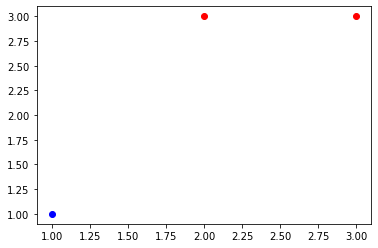

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.scatter(X[0:1, 0], X[0:1, 1], color='blue')
plt.scatter(X[1:3,0], X[1:3,1], color='red')
plt.show()
plt.clf()

#### Création des modèles

##### Modèle linéaire

In [ ]:
linear_model = my_lib.linear_create_model(ctypes.c_int(len(X[0])))

##### MLP

In [ ]:
layers = [2, 1]
layers = np.array(layers)
mlp_model = my_lib.mlp_create_model(layers.ctypes.data_as(ctypes.POINTER(ctypes.c_int)), layers.shape[0])

##### RBF

In [ ]:
rbf_model = my_lib.rbf_create_model(X.shape[0], 1)

##### SVM

In [ ]:
svm_model = my_lib.svm_create_model(X.shape[1])

#### Entrainement modèle linéaire

In [ ]:
alpha = 0.01
nb_iteration = 1000

my_lib.linear_train_model_classification(
        linear_model,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        alpha,
        nb_iteration
    )

#### Entrainement MLP

In [ ]:
alpha = 0.01
nb_iteration = 10000

my_lib.mlp_train_classification(
        mlp_model,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        1,
        alpha,
        nb_iteration
    )

#### Entrainement RBF

In [ ]:
nb_clusters_rbf = 0 # Si < 1 alors RBF naif
alpha = 5.0

my_lib.rbf_train(
        rbf_model,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        1,
        nb_clusters_rbf,
        alpha
    )

#### Entrainement SVM

In [ ]:
use_kernel_trick = False

my_lib.svm_train_model(
        svm_model,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        use_kernel_trick
)

#### Vérification des erreurs

In [ ]:
erreurs = get_erreurs(X, Y, 1, linear_model, mlp_model, rbf_model, svm_model)
print('Erreurs Linéaire : ' + str(erreurs[0]))
print('Erreurs MLP      : ' + str(erreurs[1]))
print('Erreurs RBF      : ' + str(erreurs[2]))
print('Erreurs SVM      : ' + str(erreurs[3]))

Erreurs Linéaire : 0
Erreurs MLP      : 0
Erreurs RBF      : 0
Erreurs SVM      : 1


#### Représentation visuel

##### Linéaire

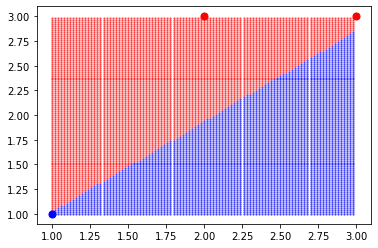

<Figure size 432x288 with 0 Axes>

In [ ]:
display_linear(X, Y, ['blue', 'red'], linear=linear_model)

##### Comme prévu le modèle linéaire trouve correctement une séparation, car cette dernière existe dans ce plan 2D

##### MLP

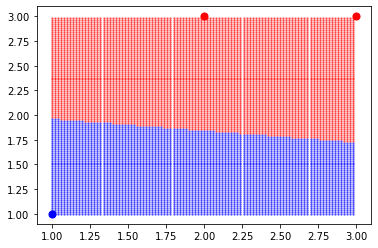

<Figure size 432x288 with 0 Axes>

In [ ]:
display_mlp(X, Y, ['blue', 'red'], mlp=mlp_model)

##### Un MLP sans couche cachée étant un modèle linéaire, sans surprise la séparation est trouvée

##### RBF

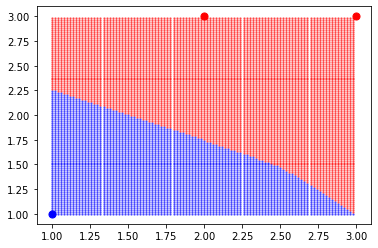

<Figure size 432x288 with 0 Axes>

In [ ]:
display_mlp(X, Y, ['blue', 'red'], rbf=rbf_model)

##### SVM

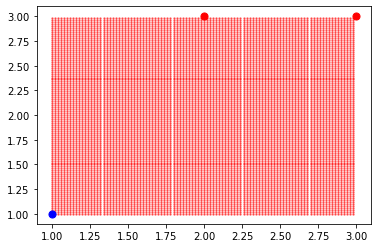

<Figure size 432x288 with 0 Axes>

In [ ]:
display_linear(X, Y, ['blue', 'red'], svm=svm_model)

### Libération des modèles

In [ ]:
dispose_models(linear=linear_model, size=len(X[0]), mlp=mlp_model, rbf=rbf_model, svm=svm_model)

### Linear Multiple :
        Linear Model : OK
        MLP (2, 1)   : OK
        RBF          : OK
        SVM          : OK

In [ ]:
X = np.concatenate([np.random.random((50,2)) * 0.9 + np.array([1, 1]), np.random.random((50,2)) * 0.9 + np.array([2, 2])])
Y = np.concatenate([np.ones((50)), np.ones((50)) * -1.0])
flattened_X = X.flatten()

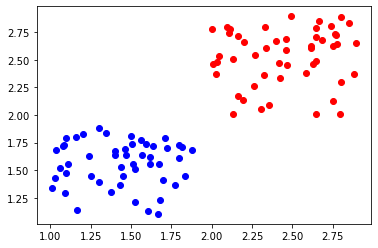

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.scatter(X[0:50, 0], X[0:50, 1], color='blue')
plt.scatter(X[50:100,0], X[50:100,1], color='red')
plt.show()
plt.clf()

#### Création des modèles

##### Modèle linéaire

In [ ]:
linear_model = my_lib.linear_create_model(ctypes.c_int(len(X[0])))

##### MLP

In [ ]:
layers = [2, 1]
layers = np.array(layers)
mlp_model = my_lib.mlp_create_model(layers.ctypes.data_as(ctypes.POINTER(ctypes.c_int)), layers.shape[0])

##### RBF

In [ ]:
rbf_model = my_lib.rbf_create_model(X.shape[0], 1)

rbf_model_clusters = my_lib.rbf_create_model(X.shape[0], 1)

##### SVM

In [ ]:
svm_model = my_lib.svm_create_model(X.shape[1])

#### Entrainement modèle linéaire

In [ ]:
alpha = 0.01
nb_iteration = 1000

my_lib.linear_train_model_classification(
        linear_model,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        alpha,
        nb_iteration
    )

#### Entrainement MLP

In [ ]:
alpha = 0.05
nb_iteration = 100000

my_lib.mlp_train_classification(
        mlp_model,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        1,
        alpha,
        nb_iteration
    )

#### Entrainement RBF

In [ ]:
nb_clusters_rbf = 0 # Si < 1 alors RBF naif
alpha = 10.0

my_lib.rbf_train(
        rbf_model,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        1,
        nb_clusters_rbf,
        alpha
    )


nb_clusters_rbf = 2

my_lib.rbf_train(
        rbf_model_clusters,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        1,
        nb_clusters_rbf,
        alpha
    )

#### Entrainement SVM

In [ ]:
use_kernel_trick = False

my_lib.svm_train_model(
        svm_model,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        use_kernel_trick
)

#### Vérification des erreurs

In [ ]:
erreurs = get_erreurs(X, Y, 1, linear_model, mlp_model, rbf_model, svm_model)
print('Erreurs Linéaire       : ' + str(erreurs[0]))
print('Erreurs MLP            : ' + str(erreurs[1]))
print('Erreurs RBF            : ' + str(erreurs[2]))
print('Erreurs RBF (clusters) : ' + str(get_erreurs(X, Y, 1, rbf=rbf_model_clusters)[2]))
print('Erreurs SVM            : ' + str(erreurs[3]))


Erreurs Linéaire       : 0
Erreurs MLP            : 0
Erreurs RBF            : 0
Erreurs RBF (clusters) : 50
Erreurs SVM            : 0


#### Représentation visuel

##### Linéaire

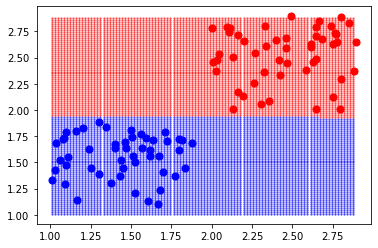

<Figure size 432x288 with 0 Axes>

In [ ]:
display_linear(X, Y, ['blue', 'red'], linear=linear_model)

##### MLP

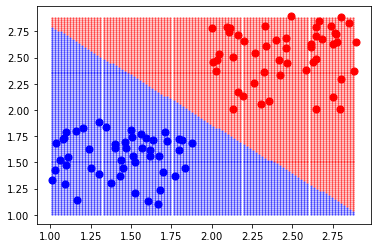

<Figure size 432x288 with 0 Axes>

In [ ]:
display_mlp(X, Y, ['blue', 'red'], mlp=mlp_model)

##### RBF

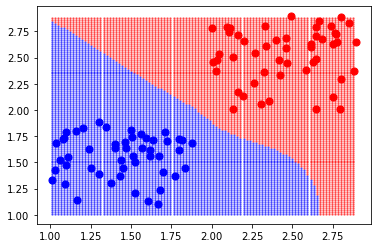

<Figure size 432x288 with 0 Axes>

In [ ]:
display_mlp(X, Y, ['blue', 'red'], rbf=rbf_model)

##### RBF (clusters)

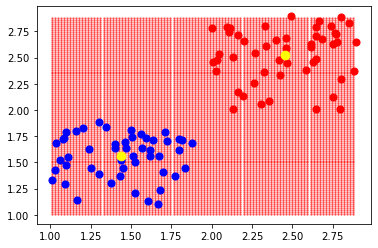

<Figure size 432x288 with 0 Axes>

In [ ]:
display_mlp(X, Y, ['blue', 'red'], rbf=rbf_model_clusters, cluster=nb_clusters_rbf)

##### SVM

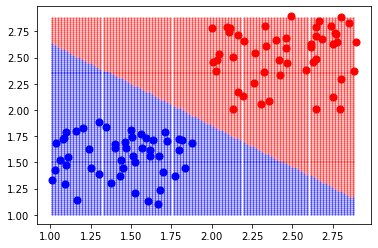

<Figure size 432x288 with 0 Axes>

In [ ]:
display_linear(X, Y, ['blue', 'red'], svm=svm_model)

### Libération des modèles

In [ ]:
dispose_models(linear=linear_model, size=len(X[0]), mlp=mlp_model, rbf=rbf_model, svm=svm_model)
dispose_models(rbf=rbf_model_clusters)

### XOR :
        Linear Model    : KO
        MLP (2, 2, 1)   : OK
        RBF             : OK
        SVM             : KO
        SVM (kernel)    : OK

In [ ]:
X = np.array([[1, 0], [0, 1], [0, 0], [1, 1]], dtype='float64')
Y = np.array([1, 1, -1, -1], dtype='float64')
flattened_X = X.flatten()

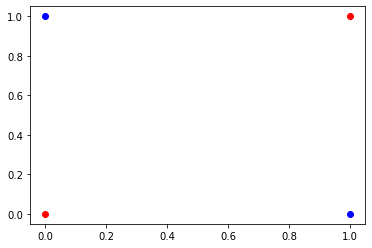

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.scatter(X[0:2, 0], X[0:2, 1], color='blue')
plt.scatter(X[2:4,0], X[2:4,1], color='red')
plt.show()
plt.clf()

#### Création des modèles

##### Modèle linéaire

In [ ]:
linear_model = my_lib.linear_create_model(ctypes.c_int(len(X[0])))

##### MLP

In [ ]:
layers = [2, 2, 1]
layers = np.array(layers)
mlp_model = my_lib.mlp_create_model(layers.ctypes.data_as(ctypes.POINTER(ctypes.c_int)), layers.shape[0])

##### RBF

In [ ]:
rbf_model = my_lib.rbf_create_model(X.shape[0], 1)

##### SVM

In [ ]:
svm_model = my_lib.svm_create_model(X.shape[1])

svm_model_kernel = my_lib.svm_create_model(X.shape[1])

#### Entrainement modèle linéaire

In [ ]:
alpha = 0.01
nb_iteration = 1000

my_lib.linear_train_model_classification(
        linear_model,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        alpha,
        nb_iteration
    )

#### Entrainement MLP

In [ ]:
alpha = 0.05
nb_iteration = 100000

my_lib.mlp_train_classification(
        mlp_model,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        1,
        alpha,
        nb_iteration
    )

#### Entrainement RBF

In [ ]:
nb_clusters_rbf = 0 # Si < 1 alors RBF naif
alpha = 5.0

my_lib.rbf_train(
        rbf_model,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        1,
        nb_clusters_rbf,
        alpha
    )

#### Entrainement SVM

In [ ]:
use_kernel_trick = False

my_lib.svm_train_model(
        svm_model,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        use_kernel_trick
)


use_kernel_trick = True

my_lib.svm_train_model(
        svm_model_kernel,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        use_kernel_trick
)

#### Vérification des erreurs

In [ ]:
erreurs = get_erreurs(X, Y, 1, linear_model, mlp_model, rbf_model, svm_model)
print('Erreurs Linéaire       : ' + str(erreurs[0]))
print('Erreurs MLP            : ' + str(erreurs[1]))
print('Erreurs RBF            : ' + str(erreurs[2]))
print('Erreurs SVM            : ' + str(erreurs[3]))
print('Erreurs SVM (kernel)   : ' + str(get_erreurs(X, Y, 1, svm=svm_model_kernel)[3]))


Erreurs Linéaire       : 2
Erreurs MLP            : 0
Erreurs RBF            : 0
Erreurs SVM            : 2
Erreurs SVM (kernel)   : 2


#### Représentation visuel

##### Linéaire

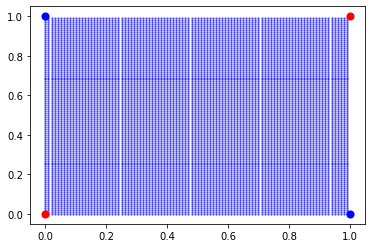

<Figure size 432x288 with 0 Axes>

In [ ]:
display_linear(X, Y, ['blue', 'red'], linear=linear_model)

##### MLP

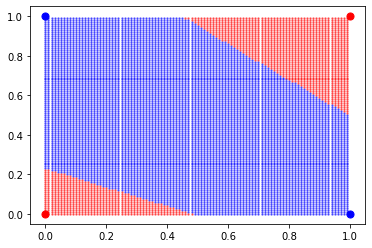

<Figure size 432x288 with 0 Axes>

In [ ]:
display_mlp(X, Y, ['blue', 'red'], mlp=mlp_model)

##### RBF

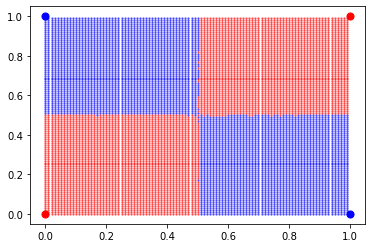

<Figure size 432x288 with 0 Axes>

In [ ]:
display_mlp(X, Y, ['blue', 'red'], rbf=rbf_model)

##### SVM

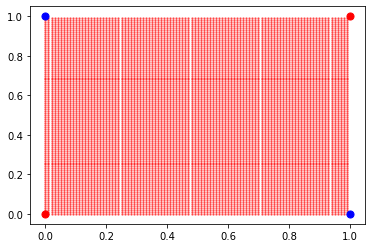

<Figure size 432x288 with 0 Axes>

In [ ]:
display_linear(X, Y, ['blue', 'red'], svm=svm_model)

##### SVM (kernel)

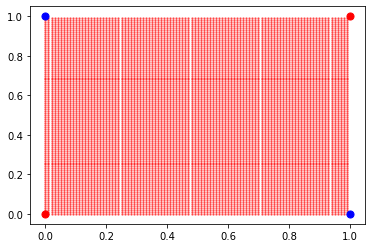

<Figure size 432x288 with 0 Axes>

In [ ]:
display_linear(X, Y, ['blue', 'red'], svm=svm_model_kernel)

### Libération des modèles

In [ ]:
dispose_models(linear=linear_model, size=len(X[0]), mlp=mlp_model, rbf=rbf_model, svm=svm_model)
dispose_models(svm=svm_model_kernel)

### Cross :
        Linear Model    : KO
        MLP (2, 4, 1)   : OK
        RBF             : OK
        SVM             : KO
        SVM (kernel)    : OK

In [ ]:
X = np.random.random((500, 2)) * 2.0 - 1.0
Y = np.array([1 if abs(p[0]) <= 0.3 or abs(p[1]) <= 0.3 else -1 for p in X], dtype='float64')
flattened_X = X.flatten()

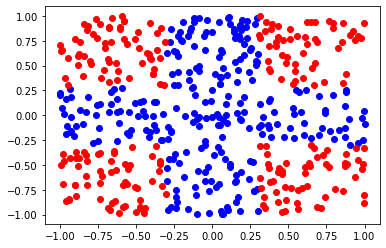

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]] == 1, enumerate(X)))))[:,1], color='blue')
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]] == -1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]] == -1, enumerate(X)))))[:,1], color='red')
plt.show()
plt.clf()

#### Création des modèles

##### Modèle linéaire

In [ ]:
linear_model = my_lib.linear_create_model(ctypes.c_int(len(X[0])))

##### MLP

In [ ]:
layers = [2, 4, 1]
layers = np.array(layers)
mlp_model = my_lib.mlp_create_model(layers.ctypes.data_as(ctypes.POINTER(ctypes.c_int)), layers.shape[0])

##### RBF

In [ ]:
rbf_model = my_lib.rbf_create_model(X.shape[0], 1)

##### SVM

In [ ]:
svm_model = my_lib.svm_create_model(X.shape[1])

svm_model_kernel = my_lib.svm_create_model(X.shape[1])

#### Entrainement modèle linéaire

In [ ]:
alpha = 0.01
nb_iteration = 1000

my_lib.linear_train_model_classification(
        linear_model,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        alpha,
        nb_iteration
    )

#### Entrainement MLP

In [ ]:
alpha = 0.05
nb_iteration = 100000

my_lib.mlp_train_classification(
        mlp_model,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        1,
        alpha,
        nb_iteration
    )

#### Entrainement RBF

In [ ]:
nb_clusters_rbf = 0 # Si < 1 alors RBF naif
alpha = 1.0

my_lib.rbf_train(
        rbf_model,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        1,
        nb_clusters_rbf,
        alpha
    )

#### Entrainement SVM

In [ ]:
use_kernel_trick = False

my_lib.svm_train_model(
        svm_model,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        use_kernel_trick
)


use_kernel_trick = True

my_lib.svm_train_model(
        svm_model_kernel,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        use_kernel_trick
)

#### Vérification des erreurs

In [ ]:
erreurs = get_erreurs(X, Y, 1, linear_model, mlp_model, rbf_model, svm_model)
print('Erreurs Linéaire       : ' + str(erreurs[0]))
print('Erreurs MLP            : ' + str(erreurs[1]))
print('Erreurs RBF            : ' + str(erreurs[2]))
print('Erreurs SVM            : ' + str(erreurs[3]))
print('Erreurs SVM (kernel)   : ' + str(get_erreurs(X, Y, 1, svm=svm_model_kernel)[3]))


Erreurs Linéaire       : 214
Erreurs MLP            : 3
Erreurs RBF            : 260
Erreurs SVM            : 255
Erreurs SVM (kernel)   : 256


#### Représentation visuel

##### Linéaire

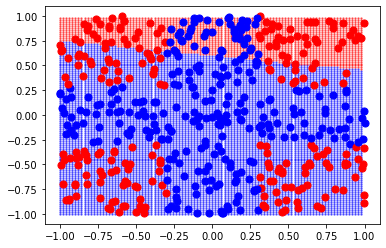

<Figure size 432x288 with 0 Axes>

In [ ]:
display_linear(X, Y, ['blue', 'red'], linear=linear_model)

##### MLP

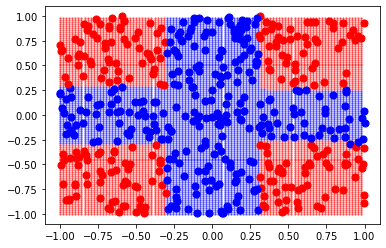

<Figure size 432x288 with 0 Axes>

In [ ]:
display_mlp(X, Y, ['blue', 'red'], mlp=mlp_model)

##### RBF

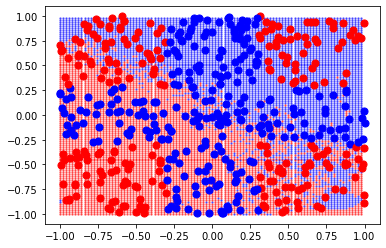

<Figure size 432x288 with 0 Axes>

In [ ]:
display_mlp(X, Y, ['blue', 'red'], rbf=rbf_model)

##### SVM

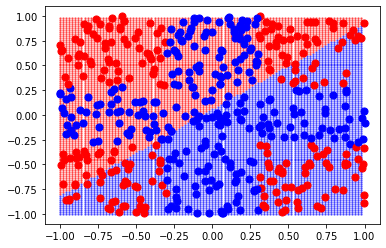

<Figure size 432x288 with 0 Axes>

In [ ]:
display_linear(X, Y, ['blue', 'red'], svm=svm_model)

##### SVM (kernel)

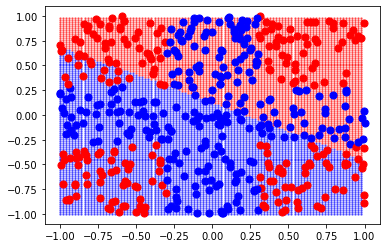

<Figure size 432x288 with 0 Axes>

In [ ]:
display_linear(X, Y, ['blue', 'red'], svm=svm_model_kernel)

### Libération des modèles

In [ ]:
dispose_models(linear=linear_model, size=len(X[0]), mlp=mlp_model, rbf=rbf_model, svm=svm_model)
dispose_models(svm=svm_model_kernel)

### Multi Linear 3 classes :
        Linear Model x3 : OK
        MLP (2, 3)      : OK
        RBF             : OK
        SVM             : KO
        SVM x3          : OK

In [ ]:
X = np.random.random((500, 2)) * 2.0 - 1.0
Y = np.array([[1, -1, -1] if -p[0] - p[1] - 0.5 > 0 and p[1] < 0 and p[0] - p[1] - 0.5 < 0 else 
              [-1, 1, -1] if -p[0] - p[1] - 0.5 < 0 and p[1] > 0 and p[0] - p[1] - 0.5 < 0 else 
              [-1, -1, 1] if -p[0] - p[1] - 0.5 < 0 and p[1] < 0 and p[0] - p[1] - 0.5 > 0 else 
              [-1, -1, -1] for p in X], dtype='float64')

Xx = []
Yy = []
for i, y in enumerate(Y):
    if y[0] != -1 or y[1] != -1 or y[2] != -1:
        Xx.append(X[i])
        Yy.append(Y[i])
        
X = np.array(Xx)
Y = np.array(Yy)
flattened_X = X.flatten()
flattened_Y = Y.flatten()

Y_blue = np.array([x[0] for x in Y])
Y_red = np.array([x[1] for x in Y])
Y_green = np.array([x[2] for x in Y])

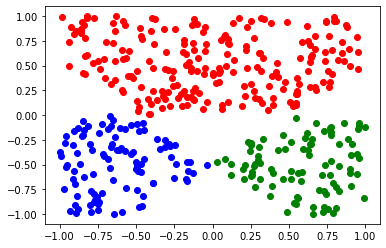

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][0] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][0] == 1, enumerate(X)))))[:,1], color='blue')
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][1] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][1] == 1, enumerate(X)))))[:,1], color='red')
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][2] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][2] == 1, enumerate(X)))))[:,1], color='green')
plt.show()
plt.clf()

#### Création des modèles

##### Modèle linéaire

In [ ]:
linear_model_blue = my_lib.linear_create_model(ctypes.c_int(len(X[0])))
linear_model_red = my_lib.linear_create_model(ctypes.c_int(len(X[0])))
linear_model_green = my_lib.linear_create_model(ctypes.c_int(len(X[0])))

##### MLP

In [ ]:
layers = [2, 3]
layers = np.array(layers)
mlp_model = my_lib.mlp_create_model(layers.ctypes.data_as(ctypes.POINTER(ctypes.c_int)), layers.shape[0])

##### RBF

In [ ]:
rbf_model = my_lib.rbf_create_model(X.shape[0], 3)

##### SVM

In [ ]:
svm_model_blue = my_lib.svm_create_model(X.shape[1])
svm_model_red = my_lib.svm_create_model(X.shape[1])
svm_model_green = my_lib.svm_create_model(X.shape[1])

#### Entrainement modèle linéaire

In [ ]:
alpha = 0.01
nb_iteration = 1000

my_lib.linear_train_model_classification(
        linear_model_blue,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        Y_blue.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        alpha,
        nb_iteration
    )
my_lib.linear_train_model_classification(
        linear_model_red,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        Y_red.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        alpha,
        nb_iteration
    )
my_lib.linear_train_model_classification(
        linear_model_green,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        Y_green.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        alpha,
        nb_iteration
    )

#### Entrainement MLP

In [ ]:
alpha = 0.005
nb_iteration = 100000

my_lib.mlp_train_classification(
        mlp_model,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        Y.shape[1],
        alpha,
        nb_iteration
    )

#### Entrainement RBF

In [ ]:
nb_clusters_rbf = 0 # Si < 1 alors RBF naif
alpha = 1.0

my_lib.rbf_train(
        rbf_model,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        Y.shape[1],
        nb_clusters_rbf,
        alpha
    )

#### Entrainement SVM

In [ ]:
use_kernel_trick = False

my_lib.svm_train_model(
        svm_model_blue,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        Y_blue.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        use_kernel_trick
)
my_lib.svm_train_model(
        svm_model_red,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        Y_red.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        use_kernel_trick
)
my_lib.svm_train_model(
        svm_model_green,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        Y_green.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        use_kernel_trick
)

#### Vérification des erreurs

In [ ]:
erreurs = get_erreurs(X, Y, 3, mlp=mlp_model, rbf=rbf_model)
print('Erreurs Linéaire blue  : ' + str(get_erreurs(X, Y_blue, 1, linear=linear_model_blue)[0]))
print('Erreurs Linéaire red   : ' + str(get_erreurs(X, Y_red, 1, linear=linear_model_red)[0]))
print('Erreurs Linéaire green : ' + str(get_erreurs(X, Y_green, 1, linear=linear_model_green)[0]))
print('Erreurs MLP            : ' + str(erreurs[1]))
print('Erreurs RBF            : ' + str(erreurs[2]))
print('Erreurs SVM blue       : ' + str(get_erreurs(X, Y_blue, 1, svm=svm_model_blue)[3]))
print('Erreurs SVM red        : ' + str(get_erreurs(X, Y_red, 1, svm=svm_model_red)[3]))
print('Erreurs SVM green      : ' + str(get_erreurs(X, Y_green, 1, svm=svm_model_green)[3]))


Erreurs Linéaire blue  : 2
Erreurs Linéaire red   : 0
Erreurs Linéaire green : 7
Erreurs MLP            : 0
Erreurs RBF            : 192
Erreurs SVM blue       : 0
Erreurs SVM red        : 0
Erreurs SVM green      : 0


#### Représentation visuel

##### Linéaire (blue)

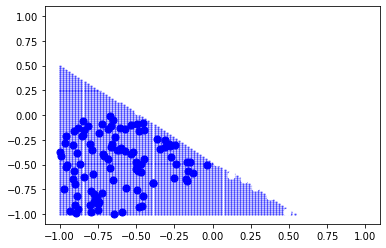

<Figure size 432x288 with 0 Axes>

In [ ]:
display_linear(X, Y_blue, ['blue', 'white'], linear=linear_model_blue)

##### Linéaire (red)

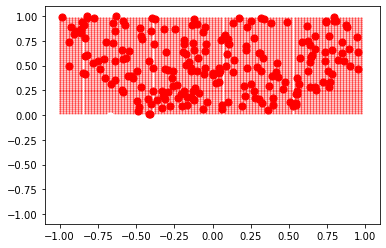

<Figure size 432x288 with 0 Axes>

In [ ]:
display_linear(X, Y_red, ['red', 'white'], linear=linear_model_red)

##### Linéaire (green)

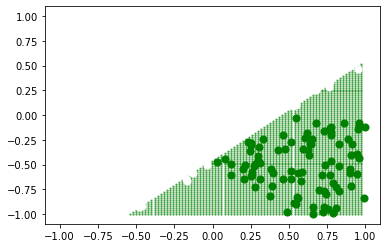

<Figure size 432x288 with 0 Axes>

In [ ]:
display_linear(X, Y_green, ['green', 'white'], linear=linear_model_green)

##### MLP

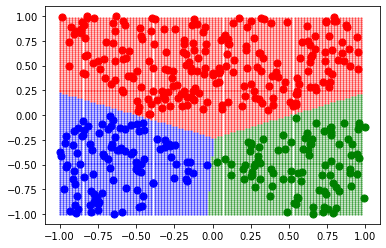

<Figure size 432x288 with 0 Axes>

In [ ]:
display_mlp(X, Y, ['blue', 'red', 'green'], mlp=mlp_model)

##### RBF

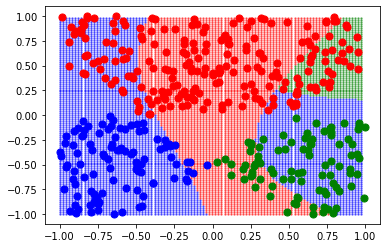

<Figure size 432x288 with 0 Axes>

In [ ]:
display_mlp(X, Y, ['blue', 'red', 'green'], rbf=rbf_model)

##### SVM (blue)

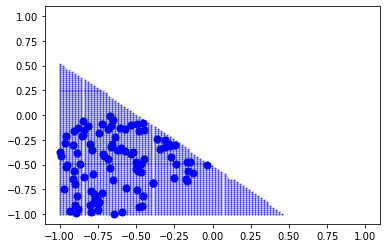

<Figure size 432x288 with 0 Axes>

In [ ]:
display_linear(X, Y_blue, ['blue', 'white'], svm=svm_model_blue)

##### SVM (red)

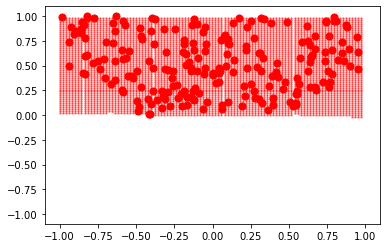

<Figure size 432x288 with 0 Axes>

In [ ]:
display_linear(X, Y_red, ['red', 'white'], svm=svm_model_red)

##### SVM (green)

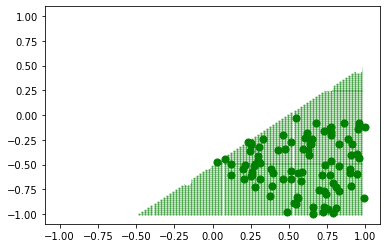

<Figure size 432x288 with 0 Axes>

In [ ]:
display_linear(X, Y_green, ['green', 'white'], svm=svm_model_green)

### Libération des modèles

In [ ]:
dispose_models(mlp=mlp_model, rbf=rbf_model)
dispose_models(linear=linear_model_blue, size=len(X[0]))
dispose_models(linear=linear_model_red, size=len(X[0]))
dispose_models(linear=linear_model_green, size=len(X[0]))
dispose_models(svm=svm_model_blue)
dispose_models(svm=svm_model_red)
dispose_models(svm=svm_model_green)

### Multi Cross :
        Linear Model x3 : KO
        MLP (2, ?, ?, 3): OK
        RBF             : OK
        SVM             : KO
        SVM (kernel) x3 : OK

In [ ]:
X = np.random.random((1000, 2)) * 2.0 - 1.0
Y = np.array([[1, -1, -1] if abs(p[0] % 0.5) <= 0.25 and abs(p[1] % 0.5) > 0.25 else [-1, 1, -1] if abs(p[0] % 0.5) > 0.25 and abs(p[1] % 0.5) <= 0.25 else [-1, -1, 1] for p in X], dtype='float64')

flattened_X = X.flatten()
flattened_Y = Y.flatten()

Y_blue = np.array([x[0] for x in Y])
Y_red = np.array([x[1] for x in Y])
Y_green = np.array([x[2] for x in Y])

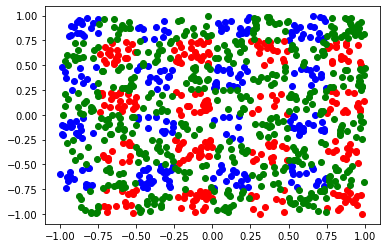

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][0] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][0] == 1, enumerate(X)))))[:,1], color='blue')
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][1] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][1] == 1, enumerate(X)))))[:,1], color='red')
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][2] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][2] == 1, enumerate(X)))))[:,1], color='green')
plt.show()
plt.clf()

#### Création des modèles

##### Modèle linéaire

In [ ]:
linear_model_blue = my_lib.linear_create_model(ctypes.c_int(len(X[0])))
linear_model_red = my_lib.linear_create_model(ctypes.c_int(len(X[0])))
linear_model_green = my_lib.linear_create_model(ctypes.c_int(len(X[0])))

##### MLP

In [ ]:
layers = [2, 30, 30, 3]
layers = np.array(layers)
mlp_model = my_lib.mlp_create_model(layers.ctypes.data_as(ctypes.POINTER(ctypes.c_int)), layers.shape[0])

##### RBF

In [ ]:
rbf_model = my_lib.rbf_create_model(X.shape[0], 3)

##### SVM

In [ ]:
svm_model_kernel = my_lib.svm_create_model(X.shape[1])

#### Entrainement modèle linéaire

In [ ]:
alpha = 0.01
nb_iteration = 1000

my_lib.linear_train_model_classification(
        linear_model_blue,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        Y_blue.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        alpha,
        nb_iteration
    )
my_lib.linear_train_model_classification(
        linear_model_red,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        Y_red.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        alpha,
        nb_iteration
    )
my_lib.linear_train_model_classification(
        linear_model_green,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        Y_green.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        alpha,
        nb_iteration
    )

#### Entrainement MLP

In [ ]:
alpha = 0.005
nb_iteration = 1000

my_lib.mlp_train_classification(
        mlp_model,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        Y.shape[1],
        alpha,
        nb_iteration
    )

#### Entrainement RBF

In [ ]:
nb_clusters_rbf = 0 # Si < 1 alors RBF naif
alpha = 1.0

my_lib.rbf_train(
        rbf_model,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        Y.shape[1],
        nb_clusters_rbf,
        alpha
    )

#### Vérification des erreurs

In [ ]:
erreurs = get_erreurs(X, Y, 3, mlp=mlp_model, rbf=rbf_model)
print('Erreurs Linéaire blue  : ' + str(get_erreurs(X, Y_blue, 1, linear=linear_model_blue)[0]))
print('Erreurs Linéaire red   : ' + str(get_erreurs(X, Y_red, 1, linear=linear_model_red)[0]))
print('Erreurs Linéaire green : ' + str(get_erreurs(X, Y_green, 1, linear=linear_model_green)[0]))
print('Erreurs MLP            : ' + str(erreurs[1]))
print('Erreurs RBF            : ' + str(erreurs[2]))

Erreurs Linéaire blue  : 239
Erreurs Linéaire red   : 336
Erreurs Linéaire green : 506
Erreurs MLP            : 69
Erreurs RBF            : 761


#### Représentation visuel

##### Linéaire (blue)

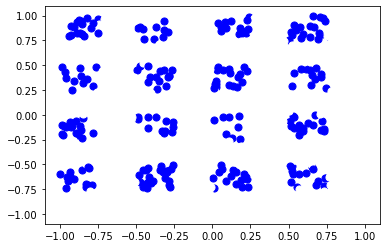

<Figure size 432x288 with 0 Axes>

In [ ]:
display_linear(X, Y_blue, ['blue', 'white'], linear=linear_model_blue)

##### Linéaire (red)

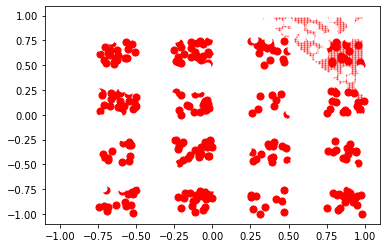

<Figure size 432x288 with 0 Axes>

In [ ]:
display_linear(X, Y_red, ['red', 'white'], linear=linear_model_red)

##### Linéaire (green)

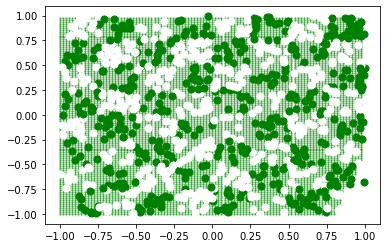

<Figure size 432x288 with 0 Axes>

In [ ]:
display_linear(X, Y_green, ['green', 'white'], linear=linear_model_green)

##### MLP

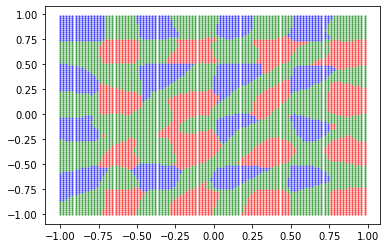

<Figure size 432x288 with 0 Axes>

In [ ]:
display_mlp(X, Y, ['blue', 'red', 'green'], mlp=mlp_model, show_points=False)

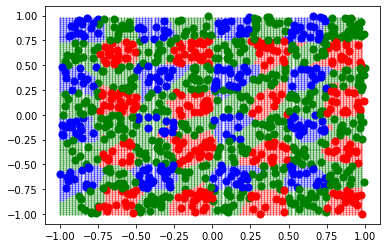

<Figure size 432x288 with 0 Axes>

In [ ]:
display_mlp(X, Y, ['blue', 'red', 'green'], mlp=mlp_model)

##### RBF

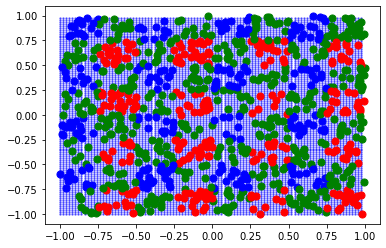

<Figure size 432x288 with 0 Axes>

In [ ]:
display_mlp(X, Y, ['blue', 'red', 'green'], rbf=rbf_model)

### Libération des modèles

In [ ]:
dispose_models(mlp=mlp_model, rbf=rbf_model)
dispose_models(linear=linear_model_blue, size=len(X[0]))
dispose_models(linear=linear_model_red, size=len(X[0]))
dispose_models(linear=linear_model_green, size=len(X[0]))

## Régression

### Linear Simple 2D :
        Linear Model : OK
        MLP (1, 1)   : OK
        RBF          : OK

In [ ]:
X = np.array([
      [1.0],
      [2.0]
])
Y = np.array([
      2.0,
      3.0
])
flattened_X = X.flatten()

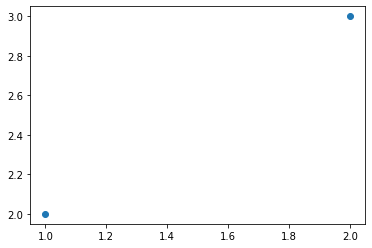

1


<Figure size 432x288 with 0 Axes>

In [ ]:
plt.scatter(X,Y)
plt.show()
plt.clf()
print(X.shape[1])

#### Création des modèles

##### Modèle linéaire

In [ ]:
linear_model = my_lib.linear_create_model(ctypes.c_int(len(X[0])))

##### MLP

In [ ]:
layers = [1, 1]
layers = np.array(layers)
mlp_model = my_lib.mlp_create_model(layers.ctypes.data_as(ctypes.POINTER(ctypes.c_int)), layers.shape[0])

##### RBF

In [ ]:
rbf_model = my_lib.rbf_create_model(X.shape[0], 1)

#### Entrainement modèle linéaire

In [ ]:
my_lib.linear_train_model_regression(
        linear_model,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1]
    )

#### Entrainement MLP

In [ ]:
alpha = 0.01
nb_iteration = 10000

my_lib.mlp_train_regression(
        mlp_model,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        1,
        alpha,
        nb_iteration
    )

#### Entrainement RBF

In [ ]:
nb_clusters_rbf = 0 # Si < 1 alors RBF naif
alpha = 0.1

my_lib.rbf_train(
        rbf_model,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        1,
        nb_clusters_rbf,
        alpha
    )

#### Représentation visuel

##### Linéaire

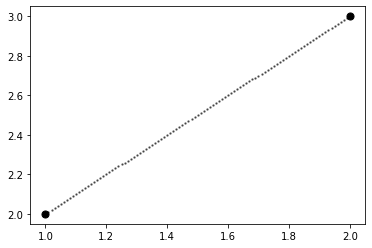

<Figure size 432x288 with 0 Axes>

In [ ]:
display_linear_regression(X, Y, linear=linear_model, nb_features=1)

##### MLP

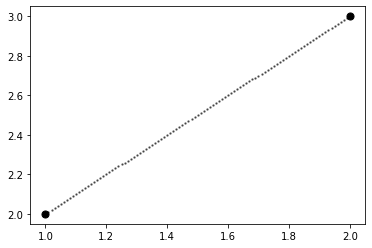

<Figure size 432x288 with 0 Axes>

In [ ]:
display_mlp_regression(X, Y, mlp=mlp_model, nb_features=1)

##### RBF

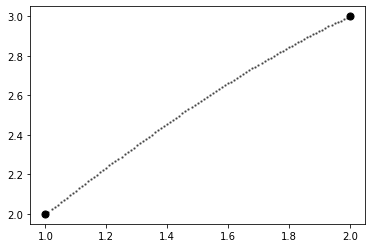

<Figure size 432x288 with 0 Axes>

In [ ]:
display_mlp_regression(X, Y, rbf=rbf_model, nb_features=1)

### Libération des modèles

In [ ]:
dispose_models(linear=linear_model, size=len(X[0]), mlp=mlp_model, rbf=rbf_model)

### Non Linear Simple 2D :
        Linear Model    : OK
        MLP (1, ?, 1)   : OK

In [ ]:
X = np.array([
      [1.0],
      [2.0],
      [3.0]
])
Y = np.array([
      2.0,
      3.0,
      2.5
])
flattened_X = X.flatten()

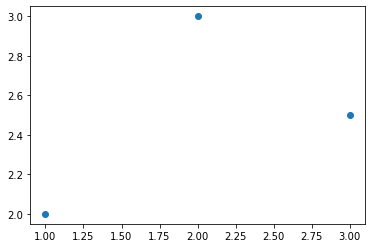

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.scatter(X,Y)
plt.show()
plt.clf()

#### Création des modèles

##### Modèle linéaire

In [ ]:
linear_model = my_lib.linear_create_model(ctypes.c_int(len(X[0])))

##### MLP

In [ ]:
layers = [1, 3, 1]
layers = np.array(layers)
mlp_model = my_lib.mlp_create_model(layers.ctypes.data_as(ctypes.POINTER(ctypes.c_int)), layers.shape[0])

##### RBF

In [ ]:
rbf_model = my_lib.rbf_create_model(X.shape[0], 1)

#### Entrainement modèle linéaire

In [ ]:
my_lib.linear_train_model_regression(
        linear_model,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1]
    )

#### Entrainement MLP

In [ ]:
alpha = 0.01
nb_iteration = 10000

my_lib.mlp_train_regression(
        mlp_model,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        1,
        alpha,
        nb_iteration
    )

#### Entrainement RBF

In [ ]:
nb_clusters_rbf = 0 # Si < 1 alors RBF naif
alpha = 0.5

my_lib.rbf_train(
        rbf_model,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        1,
        nb_clusters_rbf,
        alpha
    )

#### Représentation visuel

##### Linéaire

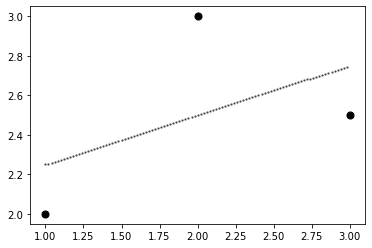

<Figure size 432x288 with 0 Axes>

In [ ]:
display_linear_regression(X, Y, linear=linear_model, nb_features=1)

##### MLP

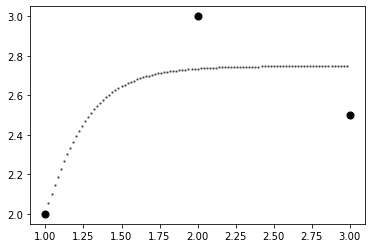

<Figure size 432x288 with 0 Axes>

In [ ]:
display_mlp_regression(X, Y, mlp=mlp_model, nb_features=1)

##### RBF

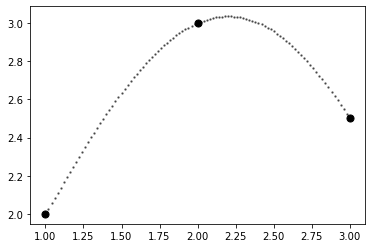

<Figure size 432x288 with 0 Axes>

In [ ]:
display_mlp_regression(X, Y, rbf=rbf_model, nb_features=1)

### Libération des modèles

In [ ]:
dispose_models(linear=linear_model, size=len(X[0]), mlp=mlp_model, rbf=rbf_model)

### Linear Simple 3D :
        Linear Model    : OK
        MLP (2, 1)      : OK

In [ ]:
X = np.array([
      [1.0, 1.0],
      [2.0, 2.0],
      [3.0, 1.0]
])
Y = np.array([
      2.0,
      3.0,
      2.5
])
flattened_X = X.flatten()

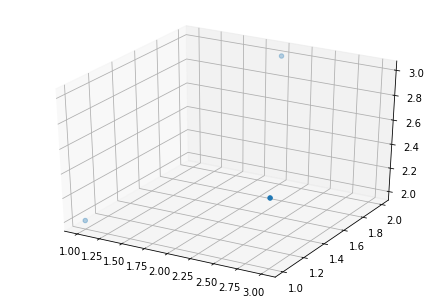

<Figure size 432x288 with 0 Axes>

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:,0],X[:,1],Y)
plt.show()
plt.clf()

#### Création des modèles

##### Modèle linéaire

In [ ]:
linear_model = my_lib.linear_create_model(ctypes.c_int(len(X[0])))

##### MLP

In [ ]:
layers = [2, 1]
layers = np.array(layers)
mlp_model = my_lib.mlp_create_model(layers.ctypes.data_as(ctypes.POINTER(ctypes.c_int)), layers.shape[0])

##### RBF

In [ ]:
rbf_model = my_lib.rbf_create_model(X.shape[0], 1)

#### Entrainement modèle linéaire

In [ ]:
my_lib.linear_train_model_regression(
        linear_model,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1]
    )

#### Entrainement MLP

In [ ]:
alpha = 0.01
nb_iteration = 10000

my_lib.mlp_train_regression(
        mlp_model,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        1,
        alpha,
        nb_iteration
    )

#### Entrainement RBF

In [ ]:
nb_clusters_rbf = 0 # Si < 1 alors RBF naif
alpha = 0.5

my_lib.rbf_train(
        rbf_model,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        1,
        nb_clusters_rbf,
        alpha
    )

#### Représentation visuel

##### Linéaire

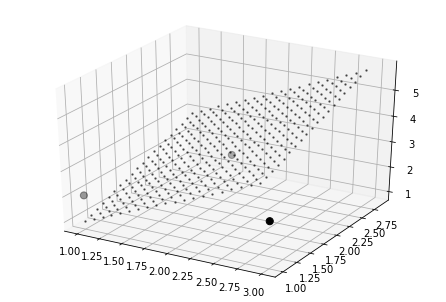

<Figure size 432x288 with 0 Axes>

In [ ]:
display_linear_regression(X, Y, linear=linear_model, nb_features=2)

##### MLP

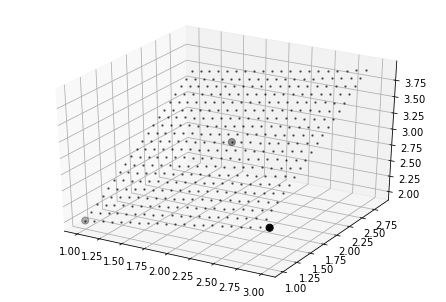

<Figure size 432x288 with 0 Axes>

In [ ]:
display_mlp_regression(X, Y, mlp=mlp_model, nb_features=2)

##### RBF

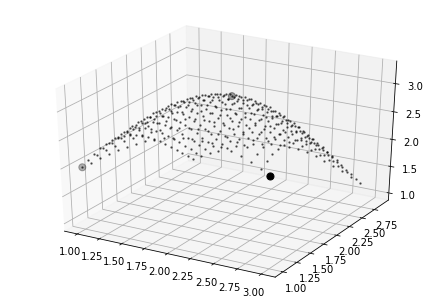

<Figure size 432x288 with 0 Axes>

In [ ]:
display_mlp_regression(X, Y, rbf=rbf_model, nb_features=2)

### Libération des modèles

In [ ]:
dispose_models(linear=linear_model, size=len(X[0]), mlp=mlp_model, rbf=rbf_model)

### Linear Tricky 3D :
        Linear Model    : OK
        MLP (2, 1)      : OK

In [ ]:
X = np.array([
      [1.0, 1.0],
      [2.0, 2.0],
      [3.0, 3.0]
])
Y = np.array([
      1.0,
      2.0,
      3.0
])
flattened_X = X.flatten()

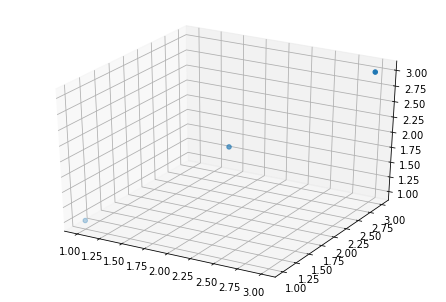

<Figure size 432x288 with 0 Axes>

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:,0],X[:,1],Y)
plt.show()
plt.clf()

#### Création des modèles

##### Modèle linéaire

In [ ]:
linear_model = my_lib.linear_create_model(ctypes.c_int(len(X[0])))

##### MLP

In [ ]:
layers = [2, 1]
layers = np.array(layers)
mlp_model = my_lib.mlp_create_model(layers.ctypes.data_as(ctypes.POINTER(ctypes.c_int)), layers.shape[0])

##### RBF

In [ ]:
rbf_model = my_lib.rbf_create_model(X.shape[0], 1)

#### Entrainement modèle linéaire

In [ ]:
my_lib.linear_train_model_regression(
        linear_model,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1]
    )

#### Entrainement MLP

In [ ]:
alpha = 0.01
nb_iteration = 10000

my_lib.mlp_train_regression(
        mlp_model,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        1,
        alpha,
        nb_iteration
    )

#### Entrainement RBF

In [ ]:
nb_clusters_rbf = 0 # Si < 1 alors RBF naif
alpha = 0.1

my_lib.rbf_train(
        rbf_model,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        1,
        nb_clusters_rbf,
        alpha
    )

#### Représentation visuel

##### Linéaire

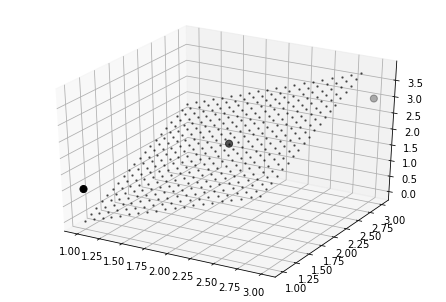

<Figure size 432x288 with 0 Axes>

In [ ]:
display_linear_regression(X, Y, linear=linear_model, nb_features=2)

##### MLP

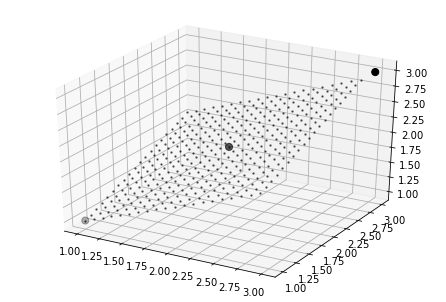

<Figure size 432x288 with 0 Axes>

In [ ]:
display_mlp_regression(X, Y, mlp=mlp_model, nb_features=2)

##### RBF

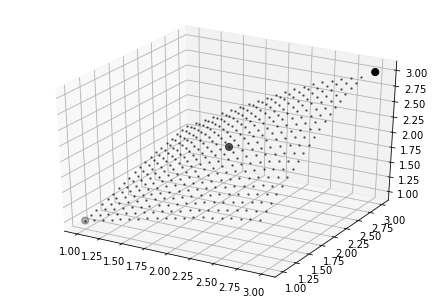

<Figure size 432x288 with 0 Axes>

In [ ]:
display_mlp_regression(X, Y, rbf=rbf_model, nb_features=2)

### Libération des modèles

In [ ]:
dispose_models(linear=linear_model, size=len(X[0]), mlp=mlp_model, rbf=rbf_model)

### Non Linear Simple 3D :
        Linear Model       : KO
        MLP (2, 2, 1)      : OK

In [ ]:
X = np.array([
      [1.0, 0.0],
      [0.0, 1.0],
      [1.0, 1.0],
      [0.0, 0.0],
])
Y = np.array([
      2.0,
      1.0,
      -2.0,
      -1.0
])
flattened_X = X.flatten()

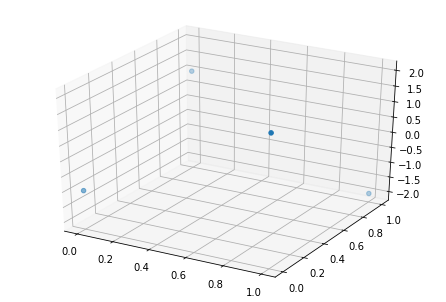

<Figure size 432x288 with 0 Axes>

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:,0],X[:,1],Y)
plt.show()
plt.clf()

#### Création des modèles

##### Modèle linéaire

In [ ]:
linear_model = my_lib.linear_create_model(ctypes.c_int(len(X[0])))

##### MLP

In [ ]:
layers = [2, 2, 1]
layers = np.array(layers)
mlp_model = my_lib.mlp_create_model(layers.ctypes.data_as(ctypes.POINTER(ctypes.c_int)), layers.shape[0])

##### RBF

In [ ]:
rbf_model = my_lib.rbf_create_model(X.shape[0], 1)

#### Entrainement modèle linéaire

In [ ]:
my_lib.linear_train_model_regression(
        linear_model,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1]
    )

#### Entrainement MLP

In [ ]:
alpha = 0.01
nb_iteration = 100000

my_lib.mlp_train_regression(
        mlp_model,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        1,
        alpha,
        nb_iteration
    )

#### Entrainement RBF

In [ ]:
nb_clusters_rbf = 0 # Si < 1 alors RBF naif
alpha = 0.1

my_lib.rbf_train(
        rbf_model,
        flattened_X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        1,
        nb_clusters_rbf,
        alpha
    )

#### Représentation visuel

##### Linéaire

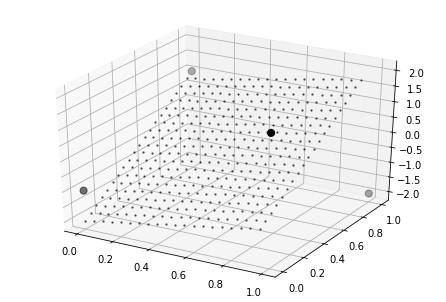

<Figure size 432x288 with 0 Axes>

In [ ]:
display_linear_regression(X, Y, linear=linear_model, nb_features=2)

##### MLP

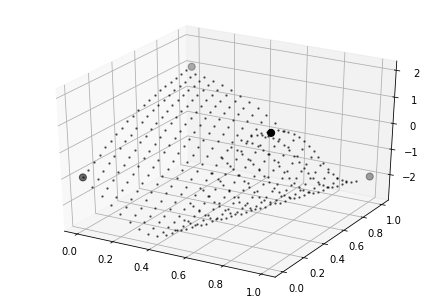

<Figure size 432x288 with 0 Axes>

In [ ]:
display_mlp_regression(X, Y, mlp=mlp_model, nb_features=2)

##### RBF

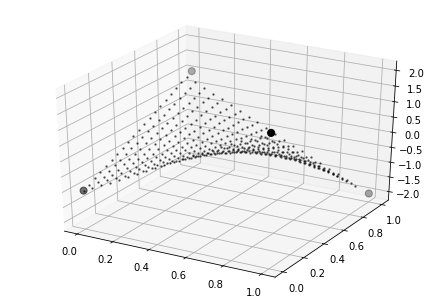

<Figure size 432x288 with 0 Axes>

In [ ]:
display_mlp_regression(X, Y, rbf=rbf_model, nb_features=2)

### Libération des modèles

In [ ]:
dispose_models(linear=linear_model, size=len(X[0]), mlp=mlp_model, rbf=rbf_model)

# Application au dataset

Maintenant que nous avons vu ce que nos algorithmes donnaient sur des cas de tests, il est temps de l'appliquer sur notre dataset.

Notre dataset est composé d'environ 1000 images de tailles différentes. Ce n'est pas super pour utiliser nos algorithmes, nous allons devoir normaliser tout cela et réduire la taille afin de ne pas faire fondre nos processeurs.

Voici le code que nous avons utilisé pour redimensionner notre dataset

In [ ]:
import sys
from PIL import Image
import os
from os import listdir
from os.path import isfile, join

# Permet de récupérer le chemin complet toutes les images du path passé en paramètre
def get_all_images(path_images):
    result = []

    images = [f for f in listdir(path_images) if isfile(join(path_images, f))]
    for img in images:
        full_path = path_images + '/' + img
        directory = os.path.dirname(os.path.realpath(full_path))
        name = os.path.splitext(os.path.basename(full_path))[0]
        extension = os.path.splitext(os.path.basename(full_path))[1]
        result.append([full_path, directory, name, extension])
    return result

# Si conserve_ratio = True alors nous allons conservé le ratio WxH
# est rajouter des bandes noires sur les cotés pour avoir une image carrée
conserve_ratio = False

# Si crop_image = True alors nous allons recadré les images avec pour centre le haut/milieu
crop_image = True

# Taille
width = 16
height = width

images = []

# Couleur de remplissage si ratio conservé
fill_color = (0, 0, 0, 0)

images = get_all_images("dataset")


for img in images:
    new_file = img[1] + '/resized/' + img[2] + '.png'
    with open(img[0], 'r+b') as f:
        with Image.open(f) as image:
            img_width, img_height = image.size

            if crop_image:
                side = min(img_width, img_height)
                left = (img_width - side) / 2
                right = (img_width + side) / 2
                top = 0
                bottom = side
                image = image.crop((left, top, right, bottom))

            if conserve_ratio:
                n_im = Image.new('RGBA', (width, height), fill_color)
                image.thumbnail((width, height), Image.ANTIALIAS)
                x, y = image.size
                n_im.paste(image, (int((width - x) / 2), int((height - y) / 2)))
            else:
                n_im = image.resize((width, height))
            n_im.save(new_file, 'PNG')
    print(new_file)

D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-0.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-1.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-10.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-100.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-101.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-102.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-103.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-104.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-105.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-106.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-107.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-108.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-109.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-11.pn

D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-209.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-21.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-210.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-211.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-212.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-213.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-214.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-215.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-216.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-217.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-218.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-219.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-22.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-22

D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-316.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-317.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-318.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-32.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-320.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-321.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-322.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-323.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-324.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-325.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-326.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-327.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-328.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-3

D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-65.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-66.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-67.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-68.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-69.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-7.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-70.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-71.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-72.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-73.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-74.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-75.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-76.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/cc-77.png
D:\Util

D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Makise-176.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Makise-178.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Makise-179.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Makise-18.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Makise-180.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Makise-181.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Makise-182.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Makise-183.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Makise-184.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Makise-185.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Makise-186.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Makise-188.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Makise-189.png
D:\Utilisateu

D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Makise-393.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Makise-394.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Makise-395.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Makise-396.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Makise-397.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Makise-398.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Makise-399.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Makise-4.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Makise-40.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Makise-400.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Makise-401.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Makise-403.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Makise-404.png
D:\Utilisateurs

D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Makise-82.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Makise-83.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Makise-84.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Makise-85.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Makise-87.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Makise-88.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Makise-89.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Makise-9.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Makise-90.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Makise-91.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Makise-92.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Makise-93.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Makise-94.png
D:\Utilisateurs\Bureau\pro

D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-199.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-2.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-20.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-200.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-201.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-202.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-203.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-204.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-205.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-207.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-208.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-209.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-211.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/r

D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-311.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-312.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-313.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-314.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-315.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-316.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-317.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-319.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-32.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-320.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-321.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-322.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-324.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset

D:\Utilisateurs\Appdata\Roaming\Python\Python36\site-packages\PIL\TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-366.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-367.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-368.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-369.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-372.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-373.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-374.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-375.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-376.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-377.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-378.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-379.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-380.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\datase

D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-59.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-6.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-61.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-62.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-63.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-64.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-69.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-7.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-71.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-73.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-74.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-75.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-76.png
D:\Utilisateurs\Bureau\projet_annuel\Rapport\dataset/resized/Rem-7

Le code ci-dessus est utilisable, mais pour des soucis de facilité, nous avons créé plusieurs datasets redimmensionnés à l'avance (16x16, 32x32, 64x64 et 128x128)

Notre dataset est maintenant normalisé, nous allons pouvoir commencer

## Entrainement sur le dataset

Fonction permettant de savoir quel neurone nous a renvoyé la plus haute valeur, et donc de déterminer la classe

In [ ]:
# Retourne l'index du neuronne ayant renvoyé la plus grande valeur
def get_classes(result, size):
    max = result[0]
    index = 0
    for i in range(size):
        if result[i] > max:
            max = result[i]
            index = i
    return index

Fonction de data augmentation maison, afin d'agrandir un peu notre dataset, si nécessaire

In [ ]:
# Permet la data augmentation
def data_augmentation(image):
    img = image.copy()
    width, height = image.size

    vertical_shift = True
    horizontal_shift = True
    vertical_flip = False
    horizontal_flip = True
    rotate = True
    brightness = True
    zoom = True

    # Shift
    pourcentage_shift = 0.3
    updown = 0
    side = 0
    if vertical_shift:
        updown = random.randint(0, math.ceil(height * pourcentage_shift))
        updown -= updown / 2
    if horizontal_shift:
        side = random.randint(0, math.ceil(width * pourcentage_shift))
        side -= side / 2
    img = img.transform(img.size, Image.AFFINE, (1, 0, side, 0, 1, updown))

    # Flip
    if vertical_flip:
        r = random.randint(0, 1)
        if r == 0:
            img = ImageOps.flip(img)
    if horizontal_flip:
        r = random.randint(0, 1)
        if r == 0:
            img = ImageOps.mirror(img)

    # Rotate
    if rotate:
        r = random.randint(-20, 20)
        img = img.rotate(r)

    # Brightness
    if brightness:
        enhancer = ImageEnhance.Brightness(img)
        r = 1 + ((random.randint(0, 100) - 50) / 100)
        img = enhancer.enhance(r)

    # Zoom
    pourcentage_zoom = 0.3
    if zoom:
        w_r = random.randint(0, math.ceil(width * pourcentage_zoom)) / 2
        h_r = random.randint(0, math.ceil(height * pourcentage_zoom)) / 2
        img = img.crop((w_r, h_r, width - w_r, height - h_r))
        img = img.resize((width, height))

    return img

In [ ]:
def train_my_model(
        dataset=16,
        data_augment=False,
        type_dataset='classic',
        nb_augment=0,
        hidden_layers=[0, 0],
        model='',
        alpha=0.005,
        iteration=100,
        save=20,            # Permet de sauvegarder le modèle ainsi que les metrics toutes les x boucles
        graph=10,           # Permet l'affichage des courbes et matrices de confusions toutes les X boucles
        like_keras=True,    # Si True alors à chaque boucle la mise à jour des poids se fera en fonction de tous les exemples
        suffle=True,        # Mélange l'ordre du dataset a chaque boucle
        path_to_save='models/'
    ):
    # Load images dataset train
    if type_dataset == 'augment':
        type = 'augment'
    else:
        type = 'classic'
        
    if dataset == 16:
        dataset_path = 'dataset_resized/16x16/' + type
    elif dataset == 32:
        dataset_path = 'dataset_resized/32x32/' + type
    elif dataset == 64:
        dataset_path = 'dataset_resized/64x64/' + type
    elif dataset == 128:
        dataset_path = 'dataset_resized/128x128/' + type
    else:
        dataset_path = dataset

    dataset_path = os.path.realpath(dataset_path)
    dataset_train_path = dataset_path + "/train"
    images_train = [f for f in listdir(dataset_train_path) if isfile(join(dataset_train_path, f))]
    dataset_train = []
    expect_outputs_train = []

    # Data augmentation
    data_augmentation_enable = False
    images_augmented = 0
    if data_augment == True:
        data_augmentation_enable = True
        try:
            images_augmented = int(nb_augment)
        except:
            images_augmented = 0

    for img in images_train:
        image = Image.open(dataset_train_path + '/' + img).convert('RGB')

        # Défini la classe en fonctio du nom de l'image, dans notre cas nos images commence par le nom du personnage
        r = [-1.0, -1.0, -1.0]
        # Rem
        if img[:1].upper() == 'R':
            r = [1.0, -1.0, -1.0]
        # CC
        elif img[:1].upper() == 'C':
            r = [-1.0, 1.0, -1.0]
        # Makise Kurisu
        elif img[:1].upper() == 'M':
            r = [-1.0, -1.0, 1.0]

        data = np.asarray(image)
        dataset_train.append(data / 255)
        expect_outputs_train.append(r)
        if data_augmentation_enable:
            for _it in range(0, images_augmented):
                data = data_augmentation(image)
                dataset_train.append(np.asarray(data) / 255)
                expect_outputs_train.append(r)

    # On refait la même chose pour les images de test (à l'expection de la data augmentation)           

    # Load images dataset test
    dataset_test_path = dataset_path + '/test'
    images_test = [f for f in listdir(dataset_test_path) if isfile(join(dataset_test_path, f))]
    dataset_test = []
    expect_outputs_test = []

    for img in images_test:
        image = Image.open(dataset_test_path + '/' + img).convert('RGB')

        r = [-1.0, -1.0, -1.0]
        if img[:1].upper() == 'R':
            r = [1.0, -1.0, -1.0]
        elif img[:1].upper() == 'C':
            r = [-1.0, 1.0, -1.0]
        elif img[:1].upper() == 'M':
            r = [-1.0, -1.0, 1.0]

        expect_outputs_test.append(r)
        data = np.asarray(image)
        dataset_test.append(data / 255)

    dataset_test = np.array(dataset_test)
    expect_outputs_test = np.array(expect_outputs_test)

    data_shape_train = np.array(dataset_train).shape
    data_shape_test = np.array(dataset_test).shape

    now = datetime.now()

    # Définitions des layers du MLP
    layers = [data_shape_train[1] * data_shape_train[2] * data_shape_train[3]]
    for i in hidden_layers:
        if i > 0:
            layers.append(i)
    layers.append(np.array(expect_outputs_train).shape[1])
    layers = np.array(layers)

    # Création du modèle
    if model == '':
        mlp_model = my_lib.mlp_create_model(layers.ctypes.data_as(ctypes.POINTER(ctypes.c_int)), layers.shape[0])
    else:
        mlp_model = my_lib.mlp_load_model(model.encode('utf-8'))

    logs = []
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []
    it = []
    now = datetime.now()
    print('Start train : ' + now.strftime("%H:%M:%S.%f"))

    save_every = save

    display_graph = graph
    
    for u in range(iteration):
        if suffle:
            # Mélange l'order du dataset à chaque boucle
            rand = random.randint(0, 100)

            random.Random(rand).shuffle(dataset_train)
            random.Random(rand).shuffle(expect_outputs_train)

        # Un entrainement
        loss = my_lib.train_with_retrieve_metrics(
            mlp_model,
            np.array(dataset_train).flatten().ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
            data_shape_train[0],
            data_shape_train[1] * data_shape_train[2] * data_shape_train[3],
            np.array(expect_outputs_train).flatten().ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
            np.array(expect_outputs_train).shape[1],
            alpha,
            True,
            like_keras
        )
        # Récupere les métrics du dataset de test
        me = my_lib.mlp_get_metrics(
            mlp_model,
            np.array(dataset_test).flatten().ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
            data_shape_test[0],
            data_shape_test[1] * data_shape_test[2] * data_shape_test[3],
            np.array(expect_outputs_test).flatten().ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
            True
        )
        it.append(u)
        train_loss.append(loss[0])
        train_acc.append(loss[1])
        test_loss.append(me[0])
        test_acc.append(me[1])

        log = str(u) + '  -  Loss : ' + '{:.5f}'.format(loss[0]) + '    - Accurate : ' + '{:.5f}'.format(loss[1]) + '    |'
        log += '    -  Loss : ' + '{:.5f}'.format(me[0]) + '    - Accurate : ' + '{:.5f}'.format(me[1])
        logs.append(log)
        print(log)
        # Permet l'affichage des logs
        if u % display_graph == 0 and u != 0:
            # les deux matrices de confusions
            print('Train ----------------------------------------')
            for i in range(layers[layers.shape[0]-1]):
                for j in range(layers[layers.shape[0]-1]):
                    print('{:>10}'.format(int(loss[i * layers[layers.shape[0]-1] + j + 2])), end='  ')
                print('')
            print('----------------------------------------------')
            print('')
            
            print('Test -----------------------------------------')
            for i in range(layers[layers.shape[0] - 1]):
                for j in range(layers[layers.shape[0] - 1]):
                    print('{:>10}'.format(int(me[i * layers[layers.shape[0] - 1] + j + 2])), end='  ')
                print('')
            print('----------------------------------------------')

            # Accuracy
            print('Train : ' + str(loss[1]))
            print('Test : ' + str(me[1]))

            # Affichage des courbes
            fig, ax = plt.subplots(2)
            ax[0].plot(it, train_loss, "-g", label="Train")
            ax[0].plot(it, test_loss, "-b", label="Test")
            ax[0].axis([-0.2, u + 1, 0, max(train_loss + test_loss) + 0.2])
            ax[0].set_title("Loss")
            ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

            ax[1].plot(it, train_acc, "-r", label="Train")
            ax[1].plot(it, test_acc, "-y", label="Test")
            ax[1].axis([-0.2, u + 1, 0, 1])
            ax[1].set_title("Acc")
            ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

        if u % save_every == 0 and u != 0:
            # Sauvegarde du modèle
            my_lib.mlp_save_model(mlp_model, str(os.path.realpath(path_to_save)).encode('utf-8'))
            print('')
            print('|******************|')
            print('|                  |')
            print('|   Modele saved   |')
            print('|                  |')
            print('|******************|')
            print('')
    return mlp_model

Quelques exemples de data augmentation fournis par notre fonction :

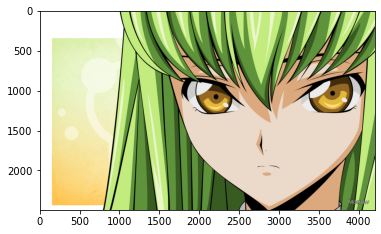

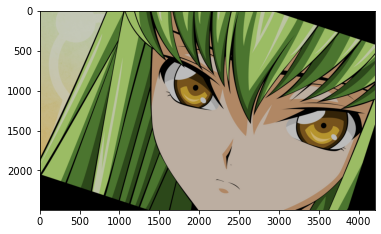

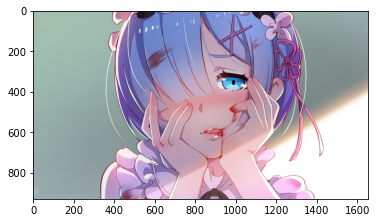

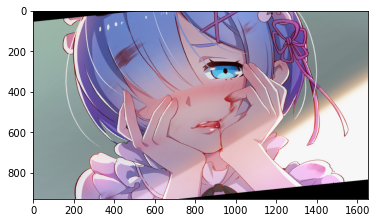

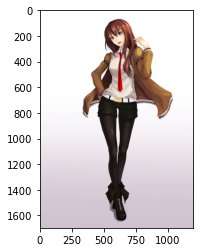

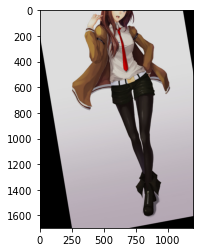

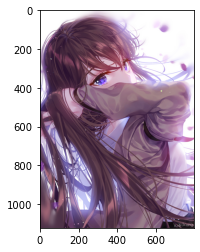

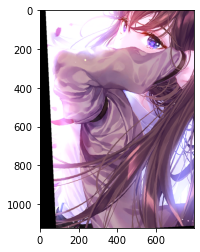

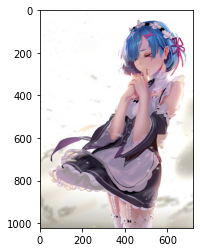

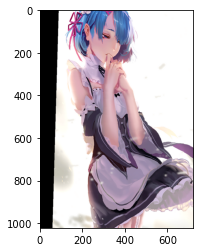

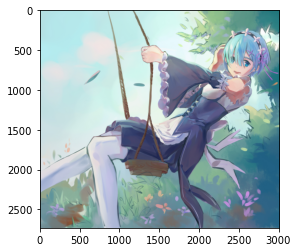

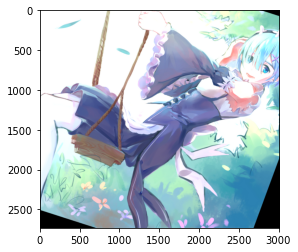

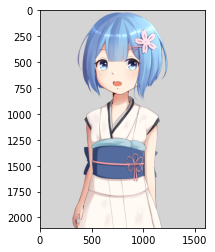

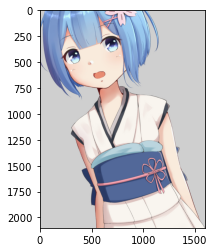

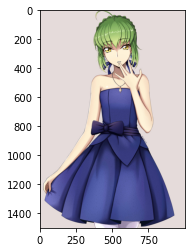

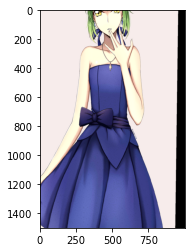

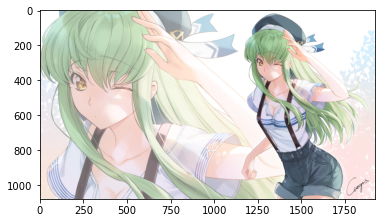

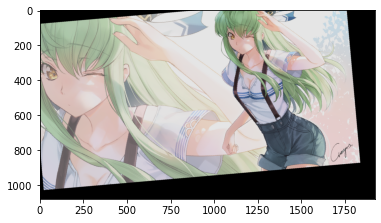

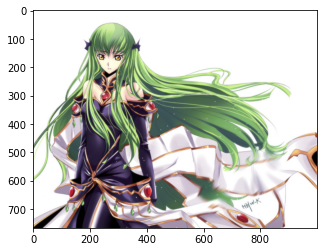

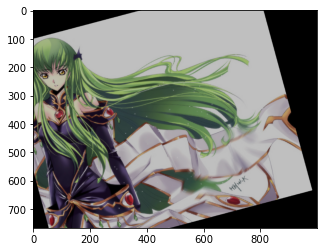

In [ ]:
nombre_image = 10

dataset = "dataset"
images = [f for f in listdir(dataset) if isfile(join(dataset, f))]
for i in range(nombre_image):
    r = random.randint(0, np.array(images).shape[0] - 2)
    img = Image.open(dataset + '/' + images[r]).convert('RGB')
    imgplot = plt.imshow(img)
    plt.show()
    img = data_augmentation(Image.open(dataset + '/' + images[r]).convert('RGB'))
    imgplot = plt.imshow(img)
    plt.show()

Nous venons de préparer tout ce que nous avions besoin, il ne reste plus qu'a faire l'entrainement

In [ ]:
model = train_my_model(
        dataset=16,
        type_dataset='classic',   #classic (pour le premier dataset) ou augment (pour le second)
        data_augment=False,
        nb_augment=0,
        hidden_layers=[128, 128],  #Sans les couches d'entrée et de sortie
        model='',
        alpha=0.005,
        iteration=2,
        save=20,            # Permet de sauvegarder le modèle ainsi que les metrics toutes les X boucles
        graph=10,           # Permet l'affichage des courbes et matrices de confusions toutes les X boucles
        like_keras=True,    # Si True alors à chaque boucle la mise à jour des poids se fera en fonction de tous les exemples
        suffle=True,        # Mélange l'ordre du dataset a chaque boucle
        path_to_save='models/'
    )
my_lib.mlp_dispose(model)

Start train : 22:54:31.764862
0  -  Loss : 1.28420    - Accurate : 0.36242    |    -  Loss : 1.32233    - Accurate : 0.35000
1  -  Loss : 1.28422    - Accurate : 0.35475    |    -  Loss : 1.33171    - Accurate : 0.32778


Afin de trouver les meilleurs paramètres pour notre modèle nous avons avancé à tâtons.

Dans un premier temps nous avons lancé des entrainements avec des modèles ayant peu d'entrées, peu de couches cachées et peu de perceptrons par couches, dans le but de faire un maximum de test.

Il nous fallait dégrossir le terrain.

Voici les premières résultats que nous avons obtenus :

    MLP : 
    [768, 128, 3]
    alpha : 0.01
    iteration : 40
    shuffle : True
    train all samples every loop : True
    images size : 16x16
[metrics complètes](metrics/mlp_16x16_rgb_metrics1.txt)

<img src='img/graph_result1.png'>

Comme nous pouvons le constater le loss est très instable, cela peut indiquer un alpha trop grand. Nous avons donc décidé de le baisser.

    MLP : 
    [768, 128, 3]
    alpha : 0.001
    iteration : 40
    shuffle : True
    train all samples every loop : True
    images size : 16x16
[metrics complètes](metrics/mlp_16x16_rgb_metrics2.txt)

<img src='img/graph_result2.png'>

C'est déjà mieux, le loss est beaucoup plus stable et descendant.

Maintenant que l'on a un alpha pas trop mal, il va falloir trouver une architecture de couche cachée qui nous permette de maximiser la précision sur les données de test.

Pour ce faire, pas le choix, il faut faire énormément de tests et comparé les metrics.

Pour bien faire, nous aimerions un modèle qui frôle les 90% de précisions sur des données de test.

Si la précision augmente puis se stabilise avant d'atteindre les 90% cela veut dire que nous sommes en underfitting, il faut modifier notre architecture (la rendre plus complexe) ou rajouter des données dans le dataset.

Si le modèle continue d'être de plus en plus performant sur les données d'entrainement mais pas sur les données de test nous sommes en overfitting, il faut rendre notre architecture moins complexe et/ou rajouter des données dans le dataset.

Si on constate que le modèle continue d'augmenter sa précision sur les données d'entrainement ET sur les données de test, on est sur la bonne voie, on continue les epochs jusqu'à l'overfitting ou jusqu'à atteindre les 90%.

Voici un entrainement plutôt concluant :

    MLP : 
    [3072, 256, 256, 3]
    alpha : 0.0005
    iteration : 120
    shuffle : True
    train all samples every loop : True
    images size : 32x32
[metrics complètes](metrics/mlp_32x32_rgb_metrics3.txt)

<img src='img/graph_result3.png'>

L'entrainement avait très bien commencé, mais nous pouvons constater un léger overfitting à partir de la 70e itération.

Dans cet entrainement nous avions inclus de la data augmentation, je vais essayer d'en mettre un peu moins et de réduire un petit peu l'alpha.

Voici les résultats que cela donne :

    MLP : 
    [3072, 256, 256, 3]
    alpha : 0.001
    iteration : 160
    shuffle : True
    train all samples every loop : True
    images size : 32x32
[metrics complètes](metrics/mlp_32x32_rgb_metrics4.txt)

<img src='img/graph_result4.png'>

Les courbes ont l'air similaires, mais en y regardant de plus près, on se rend compte que le deuxième modèle nous permet d'aller plus haut en précision sur les données de test environ 0.8

On a essayé d'avoir mieux, mais impossible jusqu'à présent le modèle ci-dessus est le meilleur que l'on ait eu.

Comment faire pour résoudre ce problème, on a essayé d'augmenter la data augmentation, mais ça rendait le modèle plus instable, on a essayé d'augmenter le nombre de perceptron par couches, mais on arrivé toujours à cette flat curve vers les 0.8/0.85.

Si changer le modèle et la data augmentation n'y fait rien, il ne nous reste qu'un levier à actionner... augmenter le dataset.

Nous sommes donc reparti à la capture d'image, et nous avons presque doublé nos données initiales (sans oublier d'augmenter les données de test aussi)

Et voilà nous avons enfin réussi à obtenir notre modèle ayant 90% de précision

    MLP : 
    [3072, 256, 256, 3]
    alpha : 0.001
    iteration : 160
    shuffle : True
    train all samples every loop : True
    images size : 32x32
[metrics complètes](metrics/mlp_32x32_rgb_metrics5.txt)

<img src='img/graph_result5.png'>

Afin de valider nos modèles, voici un petit comparatif entre notre lib et keras, pour nous rendre compte des différences ou non qu'il y a. (Attention les graduations pour les graphs du loss peuvent varier)

    MLP : 
    [3072, 256, 256, 3]
    alpha : 0.001
    iteration : 160
    shuffle : True
    train all samples every loop : True
    images size : 32x32
    entrainement sur le premier dataset

<img src='img/graph_comparatif1.png'>

    MLP : 
    [768, 128, 128, 3]
    alpha : 0.0006
    iteration : 80
    shuffle : True
    train all samples every loop : True
    images size : 16x16
    entrainement sur le deuxieme dataset
[metrics complètes](metrics/mlp_16x16_rgb_metrics5.txt)

<img src='img/graph_comparatif2.png'>

Nous remarquons que les courbes sont assez semblables, bien que keras arrive plus haut sur la précision et plus bas sur le loss des données de test, et que la courbe d'apprentissage est plus fluide malgré un alpha identique.

Regardons maintenant un peu le temps d'exécution.

Attention toutefois, cette donnée n'est pas très représentative, cela dépend du type de processeur utilisé, si le PC était en train d'effectuer d'autre tâches en parallèle, etc ...

    MLP : 
    [3072, 64, 64, 3]
    alpha : 0.001
    iteration : 40
    shuffle : True
    train all samples every loop : True
    images size : 32x32
    entrainement sur le deuxieme dataset

<img src='img/graph_comparatif_time1.png'>

Nous pouvons constater une très large différence entre les deux. Cela s'explique par plusieurs facteurs :
- keras étant un framework très connu et utilisé, il a été optimisé depuis plusieurs années
- deuxième point afin de récupérer des métrics sans trop nous prendre la tête nous avons adapté notre lib pour qu'une partie du code tourne sous python, ce qui entraîne un important échange de données entre chaque epoch.
- pour finir, en non des moindres, keras bénéficie de l'accélération graphique de nos GPU via cuda.

### Description des méthodes de save/load

Peu importe le type de modèle les méthodes se ressemble toutes, pour un souci de simplicité nos modèles sont enregistrés sous un format .txt, celui-ci n'est pas optimisé mais simple de traitement.
Il faut tout de même faire attention, avec des modèles ayant beaucoup d'entrées nous pouvons monter assez haut en taille.

Pour la sauvegarde, il faut envoyer le répertoire dans lequel nous voulons sauvegarder le modèle. Nous ne pouvons pas choisir le nom, celui-ci sera attribué automatiquement.

Assurez-vous que le répertoire cible existe, sinon l'enregistrement échouera.

Linéaire : my_lib.linear_save_model(model, nb_features, path_to_save)
MLP      : my_lib.mlp_save_model(model, path_to_save)
RBF      : my_lib.rbf_save_model(model, path_to_save)
SVM      : my_lib.svm_save_model(model, path_to_save)

Pour le chargement il faut envoyer le chemin du fichier contenant le modèle

Linéaire : my_lib.linear_load_model(model_path)
MLP      : my_lib.mlp_load_model(model_path)
RBF      : my_lib.rbf_load_model(model_path)
SVM      : my_lib.svm_load_model(model_path)

Voyons ça avec un petit exemple jouet

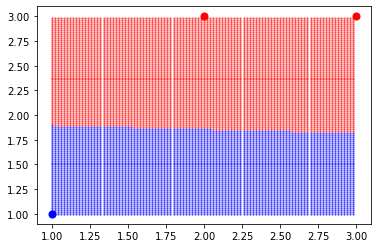

<Figure size 432x288 with 0 Axes>

In [ ]:
X = np.array([[1.0, 1.0], [2.0, 3.0], [3.0, 3.0]])
Y = np.array([1.0, -1.0, -1.0])

layers = np.array([2, 1])
model = my_lib.mlp_create_model(layers.ctypes.data_as(ctypes.POINTER(ctypes.c_int)), layers.shape[0])

my_lib.mlp_train_classification(
        model,
        X.flatten().ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[0],
        X.shape[1],
        Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        1,
        0.05,
        1000
    )

display_mlp(X, Y, ['blue', 'red'], mlp=model)

path = os.getcwd() + "/models/models_jouet"
path = path.encode('utf-8')

my_lib.mlp_save_model(model, path)

my_lib.mlp_dispose(model)

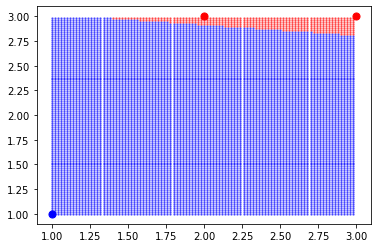

<Figure size 432x288 with 0 Axes>

In [ ]:
path_load = os.getcwd() + "/models/models_jouet/model_load.txt"
path_load = path_load.encode('utf-8')

model_load = my_lib.mlp_load_model(path_load)

display_mlp(X, Y, ['blue', 'red'], mlp=model_load)

my_lib.mlp_dispose(model_load)

Je pense que l'on a fait le tour de notre partie dédié à notre lib.

Avoir des modèles qui marchent c'est cool, mais faut-il encore pouvoir les utiliser, alors certes python permet de voir des courbes de résultats c'est bien, mais voir le modèle en action c'est mieux.

# Partie Applicative

Pour notre application, nous voulions quelque chose d'accessible de partout et simple d'utilisation

Pour satisfaire ces deux critères pas trop le choix, une application client lourd n'est pas accessible de partout et il faut l'installer. Nous sommes donc parti sur un site web.

http://92.222.76.60/app.php

<img src='img/app_explications.png'>

Le site utilise pas mal de technos différentes, HTML, CSS, PHP, JavaScript, Python, Bash. Il est hébergé sur un serveur perso (d'où l'ip) ce qui nous permet de gérer plus facilement les interactions.

Le front est géré par HTML et CSS, le traitement de l'image et le backend sont gérés en python. Bien sur mon serveur est un serveur Linux, il nous a donc fallu recompiler notre lib .dll en .so (un plaisir)

Pour faire les liens entre les deux, j'utilise du bash et de l'ajax pour un rendu plus smooth.

Pour résumé le principe, lors de l'upload de l'image celle-ci est enregistrée dans un répertoire, un script python est appelé pour la redimensionner de la même manière que les images qui ont été utilisées pour l'entrainement (tous ces paramètres sont renseignés dans une base MySql).

Après ça un second script python est appelé en différé pour exécuter la prédiction de l'image redimensionée et une fois que le modèle à fini de calculer, l'image du personnage prédit est affichée

<img src='img/app_result.png'>

# Résumé du projet

Revenons un peu sur tout ce qui s'est dit ci-dessus

Dans l'ensemble, nous sommes fières des résultats obtenus dans ce projet, alors oui c'est perfectible, notamment du côté des implémentations RBF et SVM. Mais le contrat est rempli et en bout de course nous avons ce que nous voulions, une application accessible qui permet de classer des personnages d'animes sans trop se tromper.

Lors des différentes étapes du projet, nous avons dû surmonter plusieurs difficultés, de plus cette année étant un peu particulière il a fallu intégrer au groupe un virus un peu *trop* encombrant

Voici les principales difficultés rencontrées.

- Premièrement, la compréhension des différentes formules mathématiques, la logique était là et nous la comprenions mais quand il fallait passer à l'application des formules cela se complexifier un peu, mais rien d'insurmontable non plus avec de la persévérance et du café.

- Deuxièmement, savoir comment changer les paramètres de nos modèles, pendant trop longtemps nous avons essayé en tapant au hasard sans vraiment savoir quoi modifier, ce n'est qu'assez tard dans le projet que nous avons mis en place des metrics pour comparer nos modèles entre eux.

- Troisièmement, le temps, peut-être une mauvaise organisation de notre part, mais à l'approche de la deadline, les heures de sommeil diminuaient alors que les cernes augmentaient. *Là encore le café était notre meilleur ami*.

#### Critiques des modèles

Nos modèles fonctionnent en l'état, mais ces derniers sont loin d'être très avancés. Afin de ne pas perdre trop de temps dans les entrainements nous nous sommes limité à des modèles prenant des images de 32x32.

Combiner ce facteur à nos classes qui ont une grosse différence physique, la couleur des cheveux et vous obtenez plutot des modèles qui devinent une couleur plutôt qu'un personnage à part entière.

J'en veux pour preuve cette exemple : (Rem et Ram sont soeur jumelle, seul leur couleur de cheveux change)

<img src='img/rem_ram.png'>

#### Perspectives

Si nous avions eu plus de temps nous aurions pu améliorer plusieurs aspects de notre projet.

- Entrainer nos modèles sur des images plus grandes afin de perdre le moins de détails possibles, bien que le temps ne soit pas la seule raison, nos pc n'auraient peut-être pas supportés l'entrainement de modèles immenses.

- Ajouter plus de classes (3, 4, 5, ...) nous avons un peu expérimenté ça en entrainant un modèle sur 5 classes, mais nous n'avions pas assez de data pour que cela fonctionne correctement, et nous n'avons pas voulu perdre de temps là-dessus.

- Un aspect que nous aurions bien aimé développer avec l'application aurait été un système ou l'utilisateur qui interroge le modèle peut lui spécifier si celui-ci s'est trompé, et ainsi augmenté la précision du modèle au fil des utilisations.

Voilà nous arrivons au terme de ce rapport. J'espère que notre projet vous aura convaincu, en tout cas de notre côté nous sommes fières de le présenter.

CAO Song Toan / PINTO Thomas / LECONTE Guillaume

*El psy congroo*